# A Flexible, Encoder-Decoder Framework for Image Captioning
### *Train, Evaluate, and Compare Captioning Models*

This notebook provides a comprehensive, single-file framework to train, evaluate, and compare two distinct image captioning models. The architecture is robust, reusable, and portable, inspired by professional research pipelines.

### Core Architectures for Comparison:
The primary goal is to compare two encoder-decoder architectures:
1.  **Classic Approach**: ResNet50 (Encoder) + LSTM (Decoder).
2.  **State-of-the-Art Approach**: ViT (Encoder) + Pre-trained Transformer Decoder (GPT-2).

### Key Architectural & Workflow Requirements:
- **Modular, Multi-Step Notebook**: Structured into logical cells (e.g., "Step 1: Setup", "Step 2: Configuration") for clarity.
- **Centralized Configuration**: All settings, including model choices and hyperparameters, are managed in a central `experiment_configs` dictionary.
- **Decoupled Computation and Reporting**: The main loop handles all computation first, storing results in a dictionary. A separate, final cell generates a clean, consolidated report.
- **Portable Evaluation**: Supports an "evaluate-only" mode by loading pre-trained weights from a local path or a Google Drive zip file.
- **Data Pipeline & Vocabulary**: Includes a `Vocabulary` class to handle word-to-index mapping and special tokens (`<start>`, `<end>`, `<pad>`, `<unk>`). The DataLoader uses this to numericalize captions.
- **Advanced Training**: Implements **teacher forcing**, **two-phase fine-tuning** with **differential learning rates**, **gradient accumulation**, **early stopping**, and **caption sampling** for robust training.
- **Inference and Evaluation**: A `generate_caption` function produces text for evaluation. Standard captioning metrics are calculated: **BLEU, METEOR, and CIDEr**.

### **Step 1: Environment Setup and Dependency Installation**
This cell handles the initial setup, installing necessary packages for the project. It includes the `pycocoevalcap` library and its dependency, Java, which is essential for calculating captioning metrics.

In [1]:
import os
import subprocess
import sys
import zipfile

def run_shell_command(command, shell_mode=True):
    """Executes a shell command and raises an error if it fails."""
    try:
        print(f"Running command: {command}")
        subprocess.run(command, shell=shell_mode, check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        print(f"Error executing command: {command}")
        print(e.stderr)
        raise

def setup_environment():
    """Detects the environment and installs dependencies."""
    is_colab = "google.colab" in sys.modules
    is_runpod = os.path.exists("/workspace") or "RUNPOD_POD_ID" in os.environ
    
    if is_colab or is_runpod:
        env_type = "Google Colab" if is_colab else "RunPod"
        print(f"🚀 {env_type} environment detected. Installing dependencies...")
        
        # Install Java and Zip, dependencies for pycocoevalcap and data handling
        print("Installing Java and Zip...")
        run_shell_command("apt-get update && apt-get install -y openjdk-8-jre zip")

        # Forcibly reinstall compatible Torch and Transformers versions
        print("Cleaning and reinstalling Torch and Transformers...")
        run_shell_command("pip uninstall -y torch torchvision torchaudio transformers accelerate")
        run_shell_command("pip install torch==2.2.2 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
        run_shell_command("pip install transformers==4.39.3 accelerate")

        # Install other Python packages
        print("Installing other Python packages...")
        pip_commands = [
            "pip install -q 'numpy<2.0'",
            "pip install -q pandas timm tqdm opencv-python scikit-learn nltk albumentations tabulate wandb nbformat",
            "pip install -q pycocotools pycocoevalcap kaggle matplotlib",
            "pip install -U -q ipywidgets"
        ]
        for cmd in pip_commands:
            run_shell_command(cmd)
        print(f"✅ {env_type} dependencies installed successfully.")
        
        if is_colab:
             print("\n🔥 IMPORTANT: Please restart the Colab runtime now for the new libraries to take effect! 🔥")
             print("Go to 'Runtime' > 'Restart Session' in the menu above.")
             
        return ("colab" if is_colab else "runpod"), "/content" if is_colab else "/workspace"
    else:
        print("Environment: Local machine detected.")
        return "local", os.getcwd()

def setup_from_zip(zip_path, extract_to):
    """Unzips a results archive to the base path."""
    if not os.path.exists(zip_path):
        print(f"⚠️ Zip file not found at {zip_path}. Cannot set up from zip.")
        return False
    try:
        print(f"Unzipping {zip_path} to {extract_to}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("✅ Unzipping complete.")
        return True
    except Exception as e:
        print(f"⚠️ Failed to unzip results from {zip_path}. Error: {e}")
        return False

# Run setup and define base_path globally
env_name, base_path = setup_environment()


🚀 RunPod environment detected. Installing dependencies...
Installing Java and Zip...
Running command: apt-get update && apt-get install -y openjdk-8-jre zip


Cleaning and reinstalling Torch and Transformers...
Running command: pip uninstall -y torch torchvision torchaudio transformers accelerate
Running command: pip install torch==2.2.2 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
Running command: pip install transformers==4.39.3 accelerate
Installing other Python packages...
Running command: pip install -q 'numpy<2.0'
Running command: pip install -q pandas timm tqdm opencv-python scikit-learn nltk albumentations tabulate wandb nbformat
Running command: pip install -q pycocotools pycocoevalcap kaggle matplotlib
Running command: pip install -U -q ipywidgets
✅ RunPod dependencies installed successfully.


### **Step 2: Main Imports and Experiment Configuration**
This cell imports all necessary libraries and defines the central `experiment_configs` dictionary. This is where you can easily switch between models (e.g., `resnet50_lstm` vs. `vit_gpt2`), adjust hyperparameters, and enable advanced training techniques like **two-phase training**, **gradient accumulation**, and **caption sampling**.

In [2]:
import glob
import json
import numpy as np
import pandas as pd
import random
import re 
import requests
import time
import shutil
from collections import Counter
from types import SimpleNamespace

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import timm
from transformers import AutoModel, AutoTokenizer, GPT2LMHeadModel, GPT2Tokenizer, get_cosine_schedule_with_warmup
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
import nltk
import wandb

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm

from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

class BaseCFG:
    debug = False
    epochs = 30  # Slightly more to accommodate two-phase models
    num_workers = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    force_model_retrain = False
    run_evaluation = True
    evaluate_per_epoch = True # Set to True for detailed metric tracking
    WANDB_API_KEY = "7bbf7dc1d29a93c3cd9e115741e377d149f63ee7" # Add your API key here for non-interactive login

    model_artifacts_zip_path = None

    image_size = 224
    max_length = 40  # Increased
    vocab_threshold = 3  # Lowered to allow more words

    gradient_accumulation_steps = 1
    early_stopping_patience = 10
    use_caption_sampling = True
    use_two_phase_training = True
    phase1_epochs = 5
    
experiment_configs = {
    "resnet50_lstm": {
        "models": {
            "encoder_name": "resnet50",
            "decoder_name": "lstm"
        },
        "hyperparameters": {
            "flickr8k": {
                "batch_size": 64,
                "embed_dim": 256,
                "hidden_dim": 768, # 512
                "num_layers": 1,
                "encoder_lr": 1e-4,
                "decoder_lr": 3e-4,      
                "weight_decay": 5e-4,    
                "dropout": 0.3,          
                "use_caption_sampling": True,
                "early_stopping_patience": 5, 
                "use_two_phase_training": True,
                "phase1_epochs": 8         
            },
            "flickr30k": {
                "batch_size": 96,
                "embed_dim": 512, # earlier 384
                "hidden_dim": 512,
                "num_layers": 2,
                "encoder_lr": 1e-4,
                "decoder_lr": 1.5e-4,    # From current 2e-4
                "weight_decay": 5e-4,   
                "dropout": 0.3,         
                "use_caption_sampling": True,
                "early_stopping_patience": 5, 
                "use_two_phase_training": True,
                "phase1_epochs": 10  # increased from 8      
            }
        }
    },

    "vit_gpt2": {
        "models": {
            "encoder_name": "vit_base_patch16_224",
            "decoder_name": "gpt2"
        },
        "hyperparameters": {
            "flickr8k": {
                "batch_size": 32,
                "embed_dim": 768,
                "encoder_lr": 1e-5,  # Lowered for ViT stability
                "decoder_lr": 3e-5,  # Lowered for GPT2 stability
                "weight_decay": 1e-4,
                "dropout": 0.1,      # Transformer-friendly
                "gradient_accumulation_steps": 2,
                "use_two_phase_training": True,
                "use_caption_sampling": True,
                "early_stopping_patience": 10,
                "max_length": 40
            },
            "flickr30k": {
                "batch_size": 48,
                "embed_dim": 768,
                "encoder_lr": 1e-5,
                "decoder_lr": 3e-5,
                "weight_decay": 1e-4,
                "dropout": 0.1,
                "gradient_accumulation_steps": 4,
                "use_two_phase_training": True,
                "use_caption_sampling": True,
                "early_stopping_patience": 10,
                "max_length": 40
            }
        }
    }
}

# Login to Weights & Biases
wandb_api_key = os.environ.get("WANDB_API_KEY") or BaseCFG.WANDB_API_KEY
try:
    if wandb_api_key:
        print("Logging into WandB using API key.")
        wandb.login(key=wandb_api_key)
    else:
        print("WandB API Key not found. Attempting interactive login.")
        wandb.login()
except Exception as e:
    print(f"Could not log in to WandB: {e}")
    print("Proceeding without WandB logging.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Logging into WandB using API key.


wandb: Currently logged in as: lok-nammina (lok-nammina-local) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### **Step 3: Path and Data Download Utilities**
These functions manage directory creation and handle the download and extraction of the Flickr datasets. The Flickr30k download logic has been updated to use a multi-part download from GitHub, removing the need for Kaggle API keys.

In [3]:
def generate_paths(base_path, dataset_name, cfg):
    """Generates and creates all necessary directory paths for an experiment."""
    model_combo_name = f"{dataset_name}_{cfg.encoder_name.replace('/', '-')}_{cfg.decoder_name.replace('/', '-')}"
    paths = {
        "dataset_name": dataset_name,
        "dataset_dir": os.path.join(base_path, "data", dataset_name),
        "image_dir": os.path.join(base_path, "data", dataset_name, "Images"),
        "captions_file": os.path.join(base_path, "data", dataset_name, f"{dataset_name}_captions.csv"),
        "model_save_path": os.path.join(base_path, "models", f"{model_combo_name}.pt"),
        "artifact_dir": os.path.join(base_path, "artifacts", model_combo_name),
        "vocab_path": os.path.join(base_path, "artifacts", model_combo_name, "vocab.pt"),
        "history_path": os.path.join(base_path, "artifacts", model_combo_name, "train_history.pt")
    }
    for path_key in ["dataset_dir", "artifact_dir"]:
        os.makedirs(paths[path_key], exist_ok=True)
    os.makedirs(os.path.dirname(paths["model_save_path"]), exist_ok=True)
    return paths

def download_with_progress(url, filename):
    """Downloads a file from a URL with a tqdm progress bar."""
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with requests.get(url, stream=True) as r, open(filename, 'wb') as f, tqdm(
        unit="B", unit_scale=True, unit_divisor=1024, total=int(r.headers.get('content-length', 0)),
        desc=f"Downloading {os.path.basename(filename)}"
    ) as bar:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
            bar.update(len(chunk))

def download_flickr(dataset_name, target_dir):
    """Downloads and extracts the specified Flickr dataset."""
    os.makedirs(target_dir, exist_ok=True)
    print(f"📥 Downloading {dataset_name}...")
    if dataset_name == 'flickr8k':
        url = "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip"
        zip_path = os.path.join(target_dir, "flickr8k.zip")
        download_with_progress(url, zip_path)
        run_shell_command(f"unzip -q -o {zip_path} -d {target_dir}")
        os.remove(zip_path)
    elif dataset_name == 'flickr30k':
        zip_path = os.path.join(target_dir, "flickr30k.zip")
        parts = [f"flickr30k_part0{i}" for i in range(3)]
        urls = [f"https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/{p}" for p in parts]
        part_paths = [os.path.join(target_dir, p) for p in parts]
        for url, part_path in zip(urls, part_paths):
            download_with_progress(url, part_path)
        
        run_shell_command(f"cat {' '.join(part_paths)} > {zip_path}")
        for part in part_paths:
            os.remove(part)
        run_shell_command(f"unzip -q -o {zip_path} -d {target_dir}")
        os.remove(zip_path)
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

def clean_caption(text):
    """Cleans a single caption string."""
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def process_captions(raw_captions_path, final_captions_path, cfg):
    print(f"Processing captions from {raw_captions_path}...")
    if not os.path.exists(raw_captions_path):
        print(f"❌ Missing raw captions file: {raw_captions_path}")
        return

    df = pd.read_csv(raw_captions_path)
    df.columns = df.columns.str.strip()
    df.rename(columns={"image_name": "image", "comment": "caption"}, inplace=True)
    df.dropna(subset=["caption"], inplace=True)
    df["caption"] = df["caption"].astype(str).str.strip().apply(clean_caption)
    df["num_tokens"] = df["caption"].apply(lambda x: len(x.split()))
    max_tokens = cfg.max_length - 2
    df = df[(df["num_tokens"] >= 3) & (df["num_tokens"] <= max_tokens)].reset_index(drop=True)

    df["caption_number"] = df.groupby("image").cumcount()
    df["id"] = df["image"].factorize()[0]
    df = df[["image", "caption_number", "caption", "id"]]

    df.to_csv(final_captions_path, index=False)
    print(f"\n✅ Preprocessing DONE")
    print(f"📝 Total captions: {len(df)}")
    print(f"🔤 Avg length: {df['caption'].apply(lambda x: len(x.split())).mean():.2f} tokens")
    print(f"📄 Saved: {final_captions_path}")


def prepare_dataset(config, cfg):
    """Main function to ensure dataset is downloaded and processed."""
    dataset_name = config["dataset_name"]
    dataset_dir = config["dataset_dir"]
    image_dir = config["image_dir"]
    final_captions_file = config["captions_file"]
    raw_captions_path = os.path.join(dataset_dir, 'captions.txt')

    # Stage 1: Check if the FINAL processed file exists.
    if os.path.exists(final_captions_file) and not BaseCFG.force_model_retrain:
        print(f"✅ Dataset '{dataset_name}' found and already processed. Skipping preparation.")
        return

    # Stage 2: Check if the RAW data exists.
    if not (os.path.exists(image_dir) and os.path.exists(raw_captions_path)) or BaseCFG.force_model_retrain:
        print(f"Raw dataset '{dataset_name}' not found or retraining forced. Starting download...")
        download_flickr(dataset_name, dataset_dir)
        # After download, we might have a nested folder, so let's restructure
        if not os.path.exists(image_dir) and os.path.exists(os.path.join(dataset_dir, 'flickr8k')):
            nested_dir = os.path.join(dataset_dir, 'flickr8k')
            for item in os.listdir(nested_dir):
                shutil.move(os.path.join(nested_dir, item), dataset_dir)
            shutil.rmtree(nested_dir)
        if not os.path.exists(image_dir) and os.path.exists(os.path.join(dataset_dir, 'flickr30k-images')):
            shutil.move(os.path.join(dataset_dir, 'flickr30k-images'), image_dir)
    else:
        print(f"Found raw dataset '{dataset_name}'. Skipping download.")

    # Stage 3: Process the raw data.
    print(f"Processing raw dataset...")
    process_captions(raw_captions_path, final_captions_file, cfg)
    print(f"Dataset '{dataset_name}' is now ready for use.")

### **Step 4: Vocabulary, Dataset, and DataLoader**
This is a critical section with major changes from the retrieval notebook.
- **`Vocabulary` class**: Builds a word mapping from the training captions, handling special tokens.
- **`CaptioningDataset`**: Prepares each image and its corresponding numericalized caption.
- **`get_transforms`**: Standard image augmentation for training and resizing for validation.
- **`collate_fn`**: A custom function for the DataLoader that pads caption sequences in each batch to be the same length. This is essential for batch processing in PyTorch.

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold
        self.pad_idx = self.stoi["<PAD>"]

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in word_tokenize(str(sentence)):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokenized_text = word_tokenize(str(text).lower())
        return [
            self.stoi["<SOS>"]] + [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] 
            for token in tokenized_text
        ] + [self.stoi["<EOS>"]]

class CaptioningDataset(Dataset):
    def __init__(self, df, image_dir, vocab, transforms, cfg):
        self.df = df
        self.image_dir = image_dir
        self.vocab = vocab
        self.transforms = transforms
        self.cfg = cfg
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        caption = self.df.caption.iloc[idx]
        image_id = self.df.image.iloc[idx]
        image_path = os.path.join(self.image_dir, image_id)
        
        try:
            image = Image.open(image_path).convert("RGB")
            image = np.array(image)
            image = self.transforms(image=image)['image']
        except (FileNotFoundError, OSError):
            # Return None if image is missing, collate_fn will handle it
            print(f"Warning: Could not load image {image_path}. Skipping.")
            return None

        numericalized_caption = self.vocab.numericalize(caption)
        caption_tensor = torch.tensor(numericalized_caption)
        
        return image, caption_tensor, image_id
    
    def update_df(self, new_df):
        """Allows the Trainer to update the dataframe, used for caption sampling."""
        self.df = new_df

def get_transforms(cfg, mode="train"):
    if mode == "train":
        return A.Compose([
            A.Resize(cfg.image_size, cfg.image_size),
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(cfg.image_size, cfg.image_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
        
    def __call__(self, batch):
        # Filter out None values from missing images
        batch = [b for b in batch if b is not None]
        if not batch:
            return None, None, None
        
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        image_ids = [item[2] for item in batch]
        
        return imgs, targets, image_ids
    
def make_train_valid_dfs(config):
    df = pd.read_csv(config['captions_file'])
    df = df.dropna().reset_index(drop=True)
    
    image_files_in_dir = set(os.listdir(config['image_dir']))
    df = df[df['image'].isin(image_files_in_dir)].reset_index(drop=True)
    
    # For splitting, we use unique images. For training, we use all 5 captions per image.
    unique_images = df['image'].unique()
    np.random.seed(42)
    train_mask = np.random.rand(len(unique_images)) < 0.9
    train_images = unique_images[train_mask]
    valid_images = unique_images[~train_mask]
    
    train_df = df[df['image'].isin(train_images)].reset_index(drop=True)
    # For validation, we keep all 5 captions to calculate metrics correctly
    valid_df = df[df['image'].isin(valid_images)].reset_index(drop=True)
    
    return train_df, valid_df

def build_loaders(df, image_dir, vocab, mode, config, cfg, shuffle=True):
    transforms = get_transforms(cfg, mode)
    dataset = CaptioningDataset(df, image_dir, vocab, transforms, cfg)
    
    pad_idx = vocab.pad_idx
    
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        shuffle=shuffle,
        collate_fn=Collate(pad_idx=pad_idx),
        pin_memory=True
    )
    return dataloader


### **Step 5: Model Definitions**
This cell defines the core Encoder-Decoder models.
- **`Encoder`**: A wrapper for `timm` models (ResNet50, ViT) to produce image features.
- **`Decoder`**: Separate implementations for the LSTM and the GPT-2 Transformer decoders.
- **`EncoderDecoder`**: The main model that combines an encoder and a decoder. It includes a `forward` method for training and a `generate_caption` method for inference.

In [5]:
class Encoder(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
            
    def forward(self, x):
        return self.model(x)

class LSTMDecoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, features, captions):
        embeddings = self.dropout(self.embedding(captions))
        # Correctly expand initial hidden state for multi-layer LSTMs
        h0 = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        c0 = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        hiddens, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.linear(hiddens)
        return outputs

class TransformerDecoder(nn.Module):
    def __init__(self, embed_dim, model_name="gpt2"):
        super().__init__()
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.model.config.pad_token_id = self.model.config.eos_token_id
        
        # A linear layer to project ViT's embedding dim to GPT-2's if they differ
        self.projection = nn.Linear(embed_dim, self.model.config.n_embd)
        
    def forward(self, features, captions):
        projected_features = self.projection(features).unsqueeze(1)
        caption_embeddings = self.model.transformer.wte(captions)
        inputs_embeds = torch.cat([projected_features, caption_embeddings], dim=1)
        attention_mask = torch.ones(inputs_embeds.shape[:2], dtype=torch.long, device=features.device)
        
        outputs = self.model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Drop the prediction for the initial image feature token to align sequences
        return logits[:, :-1, :]

class EncoderDecoder(nn.Module):
    def __init__(self, cfg, vocab_size):
        super().__init__()
        self.cfg = cfg
        self.encoder = Encoder(cfg.encoder_name)
        encoder_output_dim = self.encoder.model.num_features
        
        if cfg.decoder_name == "lstm":
            # For LSTM, project encoder output to match decoder's hidden_dim
            self.feature_proj = nn.Linear(encoder_output_dim, cfg.hidden_dim)
            self.decoder = LSTMDecoder(cfg.embed_dim, cfg.hidden_dim, vocab_size, cfg.num_layers, cfg.dropout)
        elif cfg.decoder_name == "gpt2":
            # GPT-2 decoder has its own projection layer
            self.decoder = TransformerDecoder(encoder_output_dim)
        else:
            raise ValueError(f"Unknown decoder: {cfg.decoder_name}")

    def set_encoder_trainable(self, trainable=True):
        """Helper function to freeze/unfreeze the encoder's weights."""
        print(f"Setting encoder trainability to: {trainable}")
        if self.cfg.encoder_name.startswith('resnet'):
            # Freeze all layers initially
            for param in self.encoder.parameters():
                param.requires_grad = False
            
            # If fine-tuning (Phase 2), unfreeze the final block
            if trainable:
                print("  - Unfreezing final block (layer4) of ResNet for fine-tuning.")
                for param in self.encoder.model.layer4.parameters():
                    param.requires_grad = True
        else: # Default behavior for other models like ViT
            for param in self.encoder.parameters():
                param.requires_grad = trainable
            
    def forward(self, images, captions):
        features = self.encoder(images)
        if self.cfg.decoder_name == "lstm":
            features = self.feature_proj(features)
            # Slicing for teacher forcing is now handled in the Trainer
            outputs = self.decoder(features, captions)
        else: # GPT-2
            outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, vocab, max_length=30):
        self.eval()
        result_caption = []
        
        with torch.no_grad():
            image = image.unsqueeze(0).to(self.cfg.device)
            features = self.encoder(image)
            
            if self.cfg.decoder_name == "lstm":
                features = self.feature_proj(features)
                states = (features.unsqueeze(0).repeat(self.decoder.lstm.num_layers, 1, 1), 
                          features.unsqueeze(0).repeat(self.decoder.lstm.num_layers, 1, 1))
                inputs = self.decoder.embedding(torch.tensor([vocab.stoi["<SOS>"]]).to(self.cfg.device)).unsqueeze(1)
                
                for _ in range(max_length):
                    hiddens, states = self.decoder.lstm(inputs, states)
                    outputs = self.decoder.linear(hiddens.squeeze(1))
                    predicted_idx = outputs.argmax(1)
                    inputs = self.decoder.embedding(predicted_idx).unsqueeze(1)
                    
                    if predicted_idx.item() == vocab.stoi["<EOS>"]:
                        break
                    result_caption.append(vocab.itos[predicted_idx.item()])
            else: # GPT-2
                features = self.decoder.projection(features).unsqueeze(1)
                attention_mask = torch.ones(features.shape[:2], dtype=torch.long, device=features.device)
                output_ids = self.decoder.model.generate(
                    inputs_embeds=features, 
                    attention_mask=attention_mask,
                    max_length=max_length, 
                    num_beams=5, 
                    early_stopping=True, 
                    pad_token_id=self.decoder.tokenizer.eos_token_id,
                    eos_token_id=self.decoder.tokenizer.eos_token_id
                )
                caption = self.decoder.tokenizer.decode(output_ids[0], skip_special_tokens=True)
                return caption.strip()
                
        return " ".join(result_caption)

### **Step 6: Trainer and Utilities**
- **`AvgMeter`**: A simple utility for tracking average metrics.
- **`Trainer`**: Manages the training and validation loops. The loops are adapted for a sequence-to-sequence task, calculating loss at each timestep.

In [6]:
class AvgMeter:
    def __init__(self, name="Metric"): self.name, self.avg, self.sum, self.count = name, 0, 0, 0
    def update(self, val, n=1): self.sum += val * n; self.count += n; self.avg = self.sum / self.count
    def __repr__(self): return f"{self.name}: {self.avg:.4f}"

class Trainer:
    def __init__(self, model, loss_fn, optimizer, scheduler, cfg):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.cfg = cfg
        self.device = cfg.device

    def _train_one_epoch(self, train_loader):
        loss_meter = AvgMeter()
        self.model.train()
        progress_bar = tqdm(train_loader, total=len(train_loader), desc="Training")
        self.optimizer.zero_grad() # Reset gradients at the start of the epoch
        
        for i, (images, captions, _) in enumerate(progress_bar):
            if images is None: continue
            images, captions = images.to(self.device), captions.to(self.device)
            
            outputs = self.model(images, captions[:, :-1])
            loss = self.loss_fn(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))
            
            # Gradient Accumulation
            loss = loss / self.cfg.gradient_accumulation_steps
            loss.backward()

            if (i + 1) % self.cfg.gradient_accumulation_steps == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()
                if self.scheduler: self.scheduler.step()
                
            loss_meter.update(loss.item() * self.cfg.gradient_accumulation_steps, images.size(0))
            progress_bar.set_postfix(train_loss=loss_meter.avg, lr=self.optimizer.param_groups[0]['lr'])
            
        return loss_meter

    def _valid_one_epoch(self, valid_loader):
        loss_meter = AvgMeter()
        self.model.eval()
        progress_bar = tqdm(valid_loader, total=len(valid_loader), desc="Validation")
        with torch.no_grad():
            for images, captions, _ in progress_bar:
                if images is None: continue
                images, captions = images.to(self.device), captions.to(self.device)
                
                outputs = self.model(images, captions[:, :-1])
                loss = self.loss_fn(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))
                
                loss_meter.update(loss.item(), images.size(0))
                progress_bar.set_postfix(valid_loss=loss_meter.avg)
        return loss_meter

    def fit(self, train_loader, valid_loader, config, start_epoch=0):
        best_loss = float('inf')
        history = {"train_loss": [], "valid_loss": [], "epoch_times": []}
        patience_counter = 0

        for epoch in range(start_epoch, self.cfg.epochs):
            epoch_start_time = time.time()
            print(f"\nEpoch: {epoch + 1}/{self.cfg.epochs}")
            
            # Caption Sampling
            current_train_loader = train_loader
            if self.cfg.use_caption_sampling:
                print("Sampling one caption per image for training this epoch...")
                sampled_df = train_loader.dataset.df.groupby('image').sample(1).reset_index(drop=True)
                current_train_loader = build_loaders(sampled_df, train_loader.dataset.image_dir, train_loader.dataset.vocab, 'train', {}, self.cfg, shuffle=True)
            
            train_loss = self._train_one_epoch(current_train_loader)
            valid_loss = self._valid_one_epoch(valid_loader)
            
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            history['train_loss'].append(train_loss.avg)
            history['valid_loss'].append(valid_loss.avg)
            history['epoch_times'].append(epoch_duration)
            
            print(f"Epoch {epoch+1} | Train Loss: {train_loss.avg:.4f} | Valid Loss: {valid_loss.avg:.4f} | Time: {epoch_duration:.2f}s")
            
            if self.cfg.evaluate_per_epoch:
                # Simplified evaluation (BLEU-4 only) for per-epoch tracking
                temp_scores, _, _ = generate_and_evaluate(self.model, valid_loader, train_loader.dataset.vocab, config)
                wandb.log({"val_bleu4": temp_scores.get("Bleu_4", 0), "epoch": epoch})

            wandb.log({"train_loss": train_loss.avg, "valid_loss": valid_loss.avg, "epoch": epoch})

            if valid_loss.avg < best_loss:
                best_loss = valid_loss.avg
                torch.save({'epoch': epoch + 1, 'model_state_dict': self.model.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()}, self.cfg.model_save_path)
                print(f"Saved Best Model! Validation Loss: {best_loss:.4f}")
                patience_counter = 0
            else:
                patience_counter += 1
                print(f"Validation loss did not improve. Patience: {patience_counter}/{self.cfg.early_stopping_patience}")
                if patience_counter >= self.cfg.early_stopping_patience:
                    print("Early stopping triggered.")
                    break
        
        return history


### **Step 7: Evaluation and Reporting Functions**
These functions handle the caption generation for the entire validation set and then use the `pycocoevalcap` library to compute standard metrics.
- **`generate_and_evaluate`**: Iterates through the validation loader, generates a caption for each image, and stores the results.
- **`get_coco_scores`**: Formats the generated captions and ground truths into the required JSON structure and runs the COCO evaluation scripts.

In [7]:
def generate_and_evaluate(model, dataloader, vocab, config):
    """Generates captions for a dataloader and prepares data for COCO evaluation."""
    print(f"Generating captions for {config['dataset_name']} validation set...")
    model.eval()
    
    results = []
    ground_truths = []
    image_ids_processed = set()
    
    with torch.no_grad():
        for images, captions_gt, image_ids in tqdm(dataloader, desc="Generating Captions"):
            if images is None: continue
            images = images.to(BaseCFG.device)
            
            for i in range(images.size(0)):
                image_id = image_ids[i]
                
                if image_id not in image_ids_processed:
                    generated_caption = model.generate_caption(images[i], vocab)
                    results.append({"image_id": image_id, "caption": generated_caption})
                    image_ids_processed.add(image_id)
    
    # Prepare ground truths from the validation dataframe
    valid_df = dataloader.dataset.df
    annotations = []
    images_info = []
    ann_id_counter = 1
    for img_id in image_ids_processed:
        images_info.append({"id": img_id})
        captions_for_image = valid_df[valid_df['image'] == img_id]['caption'].tolist()
        for cap in captions_for_image:
            annotations.append({"image_id": img_id, "id": ann_id_counter, "caption": cap})
            ann_id_counter += 1
    
    ground_truths = {
        "info": {"description": "Ground-truth captions for evaluation"},
        "images": images_info,
        "licenses": [],
        "annotations": annotations,
        "type": "captions"
    }
    
    # Calculate scores
    scores = get_coco_scores(results, ground_truths, config["artifact_dir"])
    return scores, results, ground_truths

def get_coco_scores(res, gts, artifact_dir):
    """Uses pycocoevalcap to calculate captioning metrics."""
    # Ensure artifact directory exists
    os.makedirs(artifact_dir, exist_ok=True)
    res_file = os.path.join(artifact_dir, "results.json")
    gts_file = os.path.join(artifact_dir, "ground_truths.json")
    
    with open(res_file, "w") as f:
        json.dump(res, f)
        
    with open(gts_file, "w") as f:
        json.dump(gts, f)

    coco = COCO(gts_file)
    coco_res = coco.loadRes(res_file)

    coco_eval = COCOEvalCap(coco, coco_res)
    coco_eval.evaluate()

    return coco_eval.eval

def get_parameter_counts(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


### **Step 8: The Main Pipeline Function**
This function orchestrates the entire process for a single experiment: data preparation, vocabulary building, model training (or loading), evaluation, and result aggregation. It returns a dictionary containing all results and artifacts.

In [8]:
def run_pipeline(config, cfg):
    print("-" * 50)
    print(f"STARTING PIPELINE FOR: {config['dataset_name'].upper()}")
    print(f"With model: {cfg.encoder_name} + {cfg.decoder_name}")
    print("-" * 50)
    
    # --- Setup: Data & Vocabulary ---
    print("\nSetting up datasets and vocabulary...")
    prepare_dataset(config, cfg)
    train_df, valid_df = make_train_valid_dfs(config)
    
    if train_df is None or valid_df is None or train_df.empty or valid_df.empty:
        print("Could not create dataframes. Aborting.")
        return None
        
    vocab = Vocabulary(freq_threshold=cfg.vocab_threshold)
    if os.path.exists(config["vocab_path"]) and not cfg.force_model_retrain:
        print("Loading existing vocabulary...")
        vocab = torch.load(config["vocab_path"], weights_only=False)
    else:
        print("Building new vocabulary...")
        vocab.build_vocabulary(train_df.caption.tolist())
        torch.save(vocab, config["vocab_path"])
    vocab_size = len(vocab)
    print(f"Vocabulary size: {vocab_size}")

    # Build data loaders
    train_loader = build_loaders(train_df, config['image_dir'], vocab, 'train', config, cfg, shuffle=True)
    valid_loader = build_loaders(valid_df, config['image_dir'], vocab, 'valid', config, cfg, shuffle=False)
    
    # --- Model Creation and Loading ---
    print("\nCreating model...")
    model = EncoderDecoder(cfg, vocab_size).to(cfg.device)
    cfg.model_save_path = config['model_save_path'] # Pass save path to Trainer
    
    training_history = None
    total_training_duration = 0
    
    if os.path.exists(cfg.model_save_path) and not cfg.force_model_retrain:
        print(f"Model found at '{cfg.model_save_path}'. Loading weights...")
        checkpoint = torch.load(cfg.model_save_path, map_location=cfg.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        if os.path.exists(config['history_path']):
            training_history = torch.load(config['history_path'])
    else:
        # --- Training --- #
        start_time = time.time()
        if cfg.use_two_phase_training:
            # Phase 1: Train only the decoder
            print("--- Starting Two-Phase Training: Phase 1 (Decoder Only) ---")
            model.set_encoder_trainable(False)
            decoder_params = [p for p in model.parameters() if p.requires_grad]
            optimizer = torch.optim.Adam(decoder_params, lr=cfg.decoder_lr, weight_decay=cfg.weight_decay)
            trainer = Trainer(model, nn.CrossEntropyLoss(ignore_index=vocab.pad_idx), optimizer, None, cfg)
            cfg.epochs = cfg.phase1_epochs # Temporarily set epochs for phase 1
            history1 = trainer.fit(train_loader, valid_loader, config)
            
            # Phase 2: Train the full model with differential learning rates
            print("--- Two-Phase Training: Phase 2 (Full Model with Differential LRs) ---")
            model.set_encoder_trainable(True)
            optimizer_params = [
                {"params": model.encoder.parameters(), "lr": cfg.encoder_lr},
                {"params": model.decoder.parameters(), "lr": cfg.decoder_lr}
            ]
            optimizer = torch.optim.Adam(optimizer_params, weight_decay=cfg.weight_decay)
            trainer = Trainer(model, nn.CrossEntropyLoss(ignore_index=vocab.pad_idx), optimizer, None, cfg)
            cfg.epochs = BaseCFG.epochs # Reset to original epochs
            history2 = trainer.fit(train_loader, valid_loader, config, start_epoch=cfg.phase1_epochs)
            
            # Combine histories
            training_history = {k: history1[k] + history2[k] for k in history1}
        else:
            # Standard one-phase training
            print("--- Starting Standard Training ---")
            optimizer = torch.optim.Adam(model.parameters(), lr=cfg.decoder_lr, weight_decay=cfg.weight_decay)
            trainer = Trainer(model, nn.CrossEntropyLoss(ignore_index=vocab.pad_idx), optimizer, None, cfg)
            training_history = trainer.fit(train_loader, valid_loader, config)
            
        total_training_duration = time.time() - start_time
        torch.save(training_history, config['history_path'])

    # Load the best model for final evaluation
    print("\nLoading best model for final evaluation...")
    checkpoint = torch.load(cfg.model_save_path, map_location=cfg.device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if not cfg.run_evaluation:
        print("Skipping evaluation as per configuration.")
        return {"history": training_history, "model": model, "config": config, "cfg": cfg, "vocab": vocab, "train_loader_len": len(train_loader)}

    # --- Evaluation ---
    print("\nStarting evaluation...")
    scores, generated_captions, ground_truths = generate_and_evaluate(model, valid_loader, vocab, config)
        
    print(f"\nPIPELINE FOR {config['dataset_name'].upper()} COMPLETE")
    return {
        "history": training_history,
        "metrics": scores,
        "generated_captions": generated_captions,
        "ground_truths": ground_truths,
        "model": model, 
        "config": config, 
        "cfg": cfg,
        "vocab": vocab,
        "duration": total_training_duration,
        "train_loader_len": len(train_loader)
    }


### **Step 9: Main Execution Loop**
This cell runs the main pipeline. It iterates through the `experiment_configs`, sets up the configuration for each run, and calls the `run_pipeline` function. All results are collected in the `results_history` dictionary for the final reporting step.

In [9]:
if __name__ == '__main__':
    results_history = {}
    
    if BaseCFG.model_artifacts_zip_path and setup_from_zip(BaseCFG.model_artifacts_zip_path, base_path):
        print("\n📦 Switched to 'Evaluation from Zip' mode.")
        BaseCFG.force_model_retrain = False
    
    experiments_to_run = ["resnet50_lstm"] # , "vit_gpt2"
    datasets_to_process = ["flickr8k", "flickr30k"]

    for exp_name in experiments_to_run:
        if exp_name not in experiment_configs:
            print(f"Skipping unknown experiment: {exp_name}")
            continue
            
        print("\n" + "="*80)
        print(f"                RUNNING EXPERIMENT: {exp_name.upper()}")
        print("="*80 + "\n")
        
        exp_params = experiment_configs[exp_name]
        
        for dataset_name in datasets_to_process:
            base_cfg_dict = {k: v for k, v in BaseCFG.__dict__.items() if not k.startswith('__')}
            # Overwrite base config with experiment-specific ones
            hyperparams = {**base_cfg_dict, **exp_params.get("hyperparameters", {}).get(dataset_name, {})}
            combined_params = {**hyperparams, **exp_params["models"]}
            cfg = SimpleNamespace(**combined_params)
            
            path_config = generate_paths(base_path, dataset_name, cfg)
            
            try:
                wandb.init(
                    project="image-captioning-experiments",
                    name=f"{exp_name}-{dataset_name}-{int(time.time())}",
                    config=vars(cfg)
                )
                run_results = run_pipeline(path_config, cfg)
                if run_results:
                    if dataset_name not in results_history:
                        results_history[dataset_name] = {}
                    results_history[dataset_name][exp_name] = run_results
                    wandb.log(run_results['metrics'])
            except Exception as e:
                print(f"\n❌ An error occurred during the pipeline for {exp_name} on {dataset_name}.")
                print(f"Error: {e}")
                import traceback
                traceback.print_exc()
            finally:
                wandb.finish()
                



                RUNNING EXPERIMENT: RESNET50_LSTM



--------------------------------------------------
STARTING PIPELINE FOR: FLICKR8K
With model: resnet50 + lstm
--------------------------------------------------

Setting up datasets and vocabulary...
✅ Dataset 'flickr8k' found and already processed. Skipping preparation.
Building new vocabulary...
Vocabulary size: 3916

Creating model...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


--- Starting Two-Phase Training: Phase 1 (Decoder Only) ---
Setting encoder trainability to: False

Epoch: 1/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 5.2528 | Valid Loss: 4.4057 | Time: 21.91s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 394539.17 tokens per second.
PTBTokenizer tokenized 10269 tokens at 118972.98 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9480, 'reflen': 9125, 'guess': [9480, 8690, 7900, 7110], 'correct': [4360, 1194, 241, 75]}
ratio: 1.038904109588927
Bleu_1: 0.460
Bleu_2: 0.251
Bleu_3: 0.124
Bleu_4: 0.067
computing METEOR score...
METEOR: 0.121
computing Rouge score...
ROUGE_L: 0.355
computing CIDEr score...
CIDEr: 0.098
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 13.28 s
SPICE: 0.048
Saved Best Model! Validation Loss: 4.4057

Epoch: 2/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 4.2600 | Valid Loss: 4.0206 | Time: 21.20s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 387831.01 tokens per second.
PTBTokenizer tokenized 8967 tokens at 106899.06 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8178, 'reflen': 8001, 'guess': [8178, 7388, 6598, 5808], 'correct': [4093, 1302, 309, 114]}
ratio: 1.022122234720532
Bleu_1: 0.500
Bleu_2: 0.297
Bleu_3: 0.160
Bleu_4: 0.095
computing METEOR score...
METEOR: 0.122
computing Rouge score...
ROUGE_L: 0.363
computing CIDEr score...
CIDEr: 0.080
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.43 s
SPICE: 0.050
Saved Best Model! Validation Loss: 4.0206

Epoch: 3/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 4.0061 | Valid Loss: 3.8248 | Time: 21.12s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 405444.19 tokens per second.
PTBTokenizer tokenized 11211 tokens at 131139.22 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 10422, 'reflen': 9688, 'guess': [10422, 9632, 8842, 8052], 'correct': [4620, 1558, 361, 122]}
ratio: 1.0757638315440672
Bleu_1: 0.443
Bleu_2: 0.268
Bleu_3: 0.143
Bleu_4: 0.082
computing METEOR score...
METEOR: 0.134
computing Rouge score...
ROUGE_L: 0.356
computing CIDEr score...
CIDEr: 0.134
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 15.14 s
SPICE: 0.064
Saved Best Model! Validation Loss: 3.8248

Epoch: 4/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 3.8597 | Valid Loss: 3.6963 | Time: 21.07s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 395223.40 tokens per second.
PTBTokenizer tokenized 8896 tokens at 108017.75 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8107, 'reflen': 7934, 'guess': [8107, 7317, 6527, 5737], 'correct': [4188, 1416, 368, 141]}
ratio: 1.0218048903452204
Bleu_1: 0.517
Bleu_2: 0.316
Bleu_3: 0.178
Bleu_4: 0.108
computing METEOR score...
METEOR: 0.138
computing Rouge score...
ROUGE_L: 0.375
computing CIDEr score...
CIDEr: 0.175
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.5 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.79 s
SPICE: 0.065
Saved Best Model! Validation Loss: 3.6963

Epoch: 5/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 3.7529 | Valid Loss: 3.6230 | Time: 21.44s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 373499.49 tokens per second.
PTBTokenizer tokenized 8992 tokens at 108443.53 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8203, 'reflen': 7999, 'guess': [8203, 7413, 6623, 5833], 'correct': [4202, 1421, 380, 144]}
ratio: 1.0255031878983591
Bleu_1: 0.512
Bleu_2: 0.313
Bleu_3: 0.178
Bleu_4: 0.109
computing METEOR score...
METEOR: 0.139
computing Rouge score...
ROUGE_L: 0.373
computing CIDEr score...
CIDEr: 0.175
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.11 s
SPICE: 0.063
Saved Best Model! Validation Loss: 3.6230

Epoch: 6/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 3.6827 | Valid Loss: 3.5373 | Time: 21.51s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 387297.36 tokens per second.
PTBTokenizer tokenized 8814 tokens at 130706.47 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8025, 'reflen': 7877, 'guess': [8025, 7235, 6445, 5655], 'correct': [4180, 1441, 393, 146]}
ratio: 1.018788879014724
Bleu_1: 0.521
Bleu_2: 0.322
Bleu_3: 0.185
Bleu_4: 0.113
computing METEOR score...
METEOR: 0.144
computing Rouge score...
ROUGE_L: 0.376
computing CIDEr score...
CIDEr: 0.184
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.63 s
SPICE: 0.073
Saved Best Model! Validation Loss: 3.5373

Epoch: 7/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 3.6028 | Valid Loss: 3.4786 | Time: 22.31s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 398175.97 tokens per second.
PTBTokenizer tokenized 9437 tokens at 136731.36 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8648, 'reflen': 8252, 'guess': [8648, 7858, 7068, 6278], 'correct': [4275, 1481, 394, 123]}
ratio: 1.0479883664564895
Bleu_1: 0.494
Bleu_2: 0.305
Bleu_3: 0.173
Bleu_4: 0.100
computing METEOR score...
METEOR: 0.149
computing Rouge score...
ROUGE_L: 0.377
computing CIDEr score...
CIDEr: 0.188
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.17 s
SPICE: 0.077
Saved Best Model! Validation Loss: 3.4786

Epoch: 8/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 3.5508 | Valid Loss: 3.4467 | Time: 21.29s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 406173.82 tokens per second.
PTBTokenizer tokenized 11920 tokens at 133943.02 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 11131, 'reflen': 9354, 'guess': [11131, 10341, 9551, 8761], 'correct': [4481, 1610, 461, 170]}
ratio: 1.1899722044044057
Bleu_1: 0.403
Bleu_2: 0.250
Bleu_3: 0.145
Bleu_4: 0.088
computing METEOR score...
METEOR: 0.146
computing Rouge score...
ROUGE_L: 0.362
computing CIDEr score...
CIDEr: 0.187
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.5 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 16.60 s
SPICE: 0.082
Saved Best Model! Validation Loss: 3.4467
--- Two-Phase Training: Phase 2 (Full Model with Differential LRs) ---
Setting encoder trainability to: True
  - Unfreezing final block (layer4) of ResNet for fine-tuning.

Epoch: 9/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 3.5414 | Valid Loss: 3.4182 | Time: 21.36s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 406119.08 tokens per second.
PTBTokenizer tokenized 8484 tokens at 109521.65 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7695, 'reflen': 7656, 'guess': [7695, 6905, 6115, 5325], 'correct': [4165, 1486, 422, 144]}
ratio: 1.005094043887016
Bleu_1: 0.541
Bleu_2: 0.341
Bleu_3: 0.200
Bleu_4: 0.121
computing METEOR score...
METEOR: 0.150
computing Rouge score...
ROUGE_L: 0.383
computing CIDEr score...
CIDEr: 0.217
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.5 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.74 s
SPICE: 0.080
Saved Best Model! Validation Loss: 3.4182

Epoch: 10/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 3.4959 | Valid Loss: 3.3777 | Time: 21.51s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 412262.52 tokens per second.
PTBTokenizer tokenized 12748 tokens at 154816.32 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 11959, 'reflen': 9218, 'guess': [11959, 11169, 10379, 9589], 'correct': [4384, 1550, 452, 163]}
ratio: 1.2973530049900956
Bleu_1: 0.367
Bleu_2: 0.226
Bleu_3: 0.130
Bleu_4: 0.078
computing METEOR score...
METEOR: 0.143
computing Rouge score...
ROUGE_L: 0.355
computing CIDEr score...
CIDEr: 0.180
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 14.62 s
SPICE: 0.083
Saved Best Model! Validation Loss: 3.3777

Epoch: 11/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 3.4400 | Valid Loss: 3.3546 | Time: 22.04s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 427418.18 tokens per second.
PTBTokenizer tokenized 10060 tokens at 114822.59 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9271, 'reflen': 8445, 'guess': [9271, 8481, 7691, 6901], 'correct': [4469, 1610, 461, 155]}
ratio: 1.0978093546475904
Bleu_1: 0.482
Bleu_2: 0.303
Bleu_3: 0.176
Bleu_4: 0.105
computing METEOR score...
METEOR: 0.154
computing Rouge score...
ROUGE_L: 0.382
computing CIDEr score...
CIDEr: 0.237
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.98 s
SPICE: 0.090
Saved Best Model! Validation Loss: 3.3546

Epoch: 12/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 3.4383 | Valid Loss: 3.3248 | Time: 21.77s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 368157.08 tokens per second.
PTBTokenizer tokenized 9178 tokens at 107275.72 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8389, 'reflen': 8222, 'guess': [8389, 7599, 6809, 6019], 'correct': [4435, 1670, 545, 206]}
ratio: 1.020311359766356
Bleu_1: 0.529
Bleu_2: 0.341
Bleu_3: 0.210
Bleu_4: 0.134
computing METEOR score...
METEOR: 0.160
computing Rouge score...
ROUGE_L: 0.392
computing CIDEr score...
CIDEr: 0.257
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.29 s
SPICE: 0.099
Saved Best Model! Validation Loss: 3.3248

Epoch: 13/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 3.3917 | Valid Loss: 3.3068 | Time: 22.79s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 396751.25 tokens per second.
PTBTokenizer tokenized 9361 tokens at 115031.03 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8572, 'reflen': 8204, 'guess': [8572, 7782, 6992, 6202], 'correct': [4400, 1580, 505, 197]}
ratio: 1.0448561677229344
Bleu_1: 0.513
Bleu_2: 0.323
Bleu_3: 0.196
Bleu_4: 0.124
computing METEOR score...
METEOR: 0.158
computing Rouge score...
ROUGE_L: 0.392
computing CIDEr score...
CIDEr: 0.245
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.5 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.17 s
SPICE: 0.090
Saved Best Model! Validation Loss: 3.3068

Epoch: 14/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 3.3748 | Valid Loss: 3.2852 | Time: 22.84s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 404913.31 tokens per second.
PTBTokenizer tokenized 8434 tokens at 112150.74 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7645, 'reflen': 7568, 'guess': [7645, 6855, 6065, 5275], 'correct': [4182, 1517, 433, 140]}
ratio: 1.0101744186045176
Bleu_1: 0.547
Bleu_2: 0.348
Bleu_3: 0.205
Bleu_4: 0.123
computing METEOR score...
METEOR: 0.157
computing Rouge score...
ROUGE_L: 0.389
computing CIDEr score...
CIDEr: 0.236
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.869 s
SPICE: 0.085
Saved Best Model! Validation Loss: 3.2852

Epoch: 15/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 3.3524 | Valid Loss: 3.2671 | Time: 23.11s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 416031.78 tokens per second.
PTBTokenizer tokenized 9590 tokens at 113798.22 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8801, 'reflen': 8422, 'guess': [8801, 8011, 7221, 6431], 'correct': [4517, 1656, 498, 180]}
ratio: 1.0450011873662972
Bleu_1: 0.513
Bleu_2: 0.326
Bleu_3: 0.194
Bleu_4: 0.120
computing METEOR score...
METEOR: 0.161
computing Rouge score...
ROUGE_L: 0.393
computing CIDEr score...
CIDEr: 0.254
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.22 s
SPICE: 0.093
Saved Best Model! Validation Loss: 3.2671

Epoch: 16/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 3.3288 | Valid Loss: 3.2532 | Time: 23.17s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 396402.99 tokens per second.
PTBTokenizer tokenized 10192 tokens at 120485.06 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9403, 'reflen': 8448, 'guess': [9403, 8613, 7823, 7033], 'correct': [4634, 1701, 480, 166]}
ratio: 1.1130445075756257
Bleu_1: 0.493
Bleu_2: 0.312
Bleu_3: 0.181
Bleu_4: 0.109
computing METEOR score...
METEOR: 0.161
computing Rouge score...
ROUGE_L: 0.387
computing CIDEr score...
CIDEr: 0.249
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.80 s
SPICE: 0.094
Saved Best Model! Validation Loss: 3.2532

Epoch: 17/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 3.3036 | Valid Loss: 3.2347 | Time: 23.23s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 390667.30 tokens per second.
PTBTokenizer tokenized 9740 tokens at 132931.10 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8951, 'reflen': 8409, 'guess': [8951, 8161, 7371, 6581], 'correct': [4565, 1703, 516, 181]}
ratio: 1.0644547508620448
Bleu_1: 0.510
Bleu_2: 0.326
Bleu_3: 0.195
Bleu_4: 0.120
computing METEOR score...
METEOR: 0.163
computing Rouge score...
ROUGE_L: 0.396
computing CIDEr score...
CIDEr: 0.256
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.22 s
SPICE: 0.098
Saved Best Model! Validation Loss: 3.2347

Epoch: 18/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 3.3005 | Valid Loss: 3.2204 | Time: 23.35s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 426396.53 tokens per second.
PTBTokenizer tokenized 9519 tokens at 131200.85 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8730, 'reflen': 8228, 'guess': [8730, 7940, 7150, 6360], 'correct': [4558, 1691, 509, 164]}
ratio: 1.0610111813319079
Bleu_1: 0.522
Bleu_2: 0.333
Bleu_3: 0.199
Bleu_4: 0.120
computing METEOR score...
METEOR: 0.163
computing Rouge score...
ROUGE_L: 0.399
computing CIDEr score...
CIDEr: 0.280
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.09 s
SPICE: 0.099
Saved Best Model! Validation Loss: 3.2204

Epoch: 19/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 3.2847 | Valid Loss: 3.2155 | Time: 22.95s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 378775.76 tokens per second.
PTBTokenizer tokenized 9787 tokens at 121496.62 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8998, 'reflen': 8570, 'guess': [8998, 8208, 7418, 6628], 'correct': [4661, 1774, 599, 235]}
ratio: 1.0499416569427011
Bleu_1: 0.518
Bleu_2: 0.335
Bleu_3: 0.208
Bleu_4: 0.134
computing METEOR score...
METEOR: 0.167
computing Rouge score...
ROUGE_L: 0.401
computing CIDEr score...
CIDEr: 0.279
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.5 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.46 s
SPICE: 0.101
Saved Best Model! Validation Loss: 3.2155

Epoch: 20/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 3.2666 | Valid Loss: 3.2095 | Time: 23.41s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 395090.54 tokens per second.
PTBTokenizer tokenized 8945 tokens at 108703.22 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8156, 'reflen': 7991, 'guess': [8156, 7366, 6576, 5786], 'correct': [4439, 1690, 530, 177]}
ratio: 1.0206482292577874
Bleu_1: 0.544
Bleu_2: 0.353
Bleu_3: 0.216
Bleu_4: 0.132
computing METEOR score...
METEOR: 0.167
computing Rouge score...
ROUGE_L: 0.403
computing CIDEr score...
CIDEr: 0.292
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.02 s
SPICE: 0.101
Saved Best Model! Validation Loss: 3.2095

Epoch: 21/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 3.2650 | Valid Loss: 3.1981 | Time: 23.35s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 384911.20 tokens per second.
PTBTokenizer tokenized 10715 tokens at 131182.80 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9926, 'reflen': 9018, 'guess': [9926, 9136, 8346, 7556], 'correct': [4850, 1843, 568, 180]}
ratio: 1.1006875138610444
Bleu_1: 0.489
Bleu_2: 0.314
Bleu_3: 0.189
Bleu_4: 0.112
computing METEOR score...
METEOR: 0.166
computing Rouge score...
ROUGE_L: 0.396
computing CIDEr score...
CIDEr: 0.273
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.52 s
SPICE: 0.101
Saved Best Model! Validation Loss: 3.1981

Epoch: 22/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 3.2325 | Valid Loss: 3.1922 | Time: 23.17s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 408095.92 tokens per second.
PTBTokenizer tokenized 9772 tokens at 122796.86 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8983, 'reflen': 8594, 'guess': [8983, 8193, 7403, 6613], 'correct': [4710, 1826, 570, 202]}
ratio: 1.045264137770416
Bleu_1: 0.524
Bleu_2: 0.342
Bleu_3: 0.208
Bleu_4: 0.129
computing METEOR score...
METEOR: 0.169
computing Rouge score...
ROUGE_L: 0.403
computing CIDEr score...
CIDEr: 0.280
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.64 s
SPICE: 0.100
Saved Best Model! Validation Loss: 3.1922

Epoch: 23/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 3.2340 | Valid Loss: 3.1702 | Time: 22.52s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 381937.53 tokens per second.
PTBTokenizer tokenized 9868 tokens at 139157.57 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9079, 'reflen': 8373, 'guess': [9079, 8289, 7499, 6709], 'correct': [4652, 1784, 541, 192]}
ratio: 1.084318643257962
Bleu_1: 0.512
Bleu_2: 0.332
Bleu_3: 0.200
Bleu_4: 0.123
computing METEOR score...
METEOR: 0.167
computing Rouge score...
ROUGE_L: 0.400
computing CIDEr score...
CIDEr: 0.295
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.72 s
SPICE: 0.100
Saved Best Model! Validation Loss: 3.1702

Epoch: 24/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 3.2079 | Valid Loss: 3.1729 | Time: 22.98s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 434683.62 tokens per second.
PTBTokenizer tokenized 11724 tokens at 142732.85 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 10935, 'reflen': 9405, 'guess': [10935, 10145, 9355, 8565], 'correct': [4984, 1895, 640, 257]}
ratio: 1.1626794258371969
Bleu_1: 0.456
Bleu_2: 0.292
Bleu_3: 0.180
Bleu_4: 0.115
computing METEOR score...
METEOR: 0.163
computing Rouge score...
ROUGE_L: 0.389
computing CIDEr score...
CIDEr: 0.274
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.85 s
SPICE: 0.107
Validation loss did not improve. Patience: 1/5

Epoch: 25/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 3.2083 | Valid Loss: 3.1644 | Time: 23.09s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 398588.12 tokens per second.
PTBTokenizer tokenized 9989 tokens at 128896.26 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9200, 'reflen': 8552, 'guess': [9200, 8410, 7620, 6830], 'correct': [4775, 1878, 629, 233]}
ratio: 1.075771749298284
Bleu_1: 0.519
Bleu_2: 0.340
Bleu_3: 0.212
Bleu_4: 0.134
computing METEOR score...
METEOR: 0.171
computing Rouge score...
ROUGE_L: 0.408
computing CIDEr score...
CIDEr: 0.321
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.43 s
SPICE: 0.108
Saved Best Model! Validation Loss: 3.1644

Epoch: 26/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 3.2040 | Valid Loss: 3.1553 | Time: 23.14s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 407525.65 tokens per second.
PTBTokenizer tokenized 9569 tokens at 121140.86 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8780, 'reflen': 8455, 'guess': [8780, 7990, 7200, 6410], 'correct': [4710, 1803, 602, 222]}
ratio: 1.0384387936131236
Bleu_1: 0.536
Bleu_2: 0.348
Bleu_3: 0.216
Bleu_4: 0.137
computing METEOR score...
METEOR: 0.170
computing Rouge score...
ROUGE_L: 0.406
computing CIDEr score...
CIDEr: 0.301
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.72 s
SPICE: 0.109
Saved Best Model! Validation Loss: 3.1553

Epoch: 27/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 3.1927 | Valid Loss: 3.1603 | Time: 23.12s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 366841.92 tokens per second.
PTBTokenizer tokenized 10159 tokens at 122536.01 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9370, 'reflen': 8595, 'guess': [9370, 8580, 7790, 7000], 'correct': [4773, 1824, 564, 184]}
ratio: 1.0901687027340208
Bleu_1: 0.509
Bleu_2: 0.329
Bleu_3: 0.199
Bleu_4: 0.120
computing METEOR score...
METEOR: 0.169
computing Rouge score...
ROUGE_L: 0.409
computing CIDEr score...
CIDEr: 0.298
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.5 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.85 s
SPICE: 0.104
Validation loss did not improve. Patience: 1/5

Epoch: 28/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 3.1893 | Valid Loss: 3.1402 | Time: 22.93s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 411304.65 tokens per second.
PTBTokenizer tokenized 10301 tokens at 146906.64 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9512, 'reflen': 8693, 'guess': [9512, 8722, 7932, 7142], 'correct': [4914, 1909, 589, 209]}
ratio: 1.0942137351891068
Bleu_1: 0.517
Bleu_2: 0.336
Bleu_3: 0.203
Bleu_4: 0.125
computing METEOR score...
METEOR: 0.172
computing Rouge score...
ROUGE_L: 0.408
computing CIDEr score...
CIDEr: 0.313
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.79 s
SPICE: 0.107
Saved Best Model! Validation Loss: 3.1402

Epoch: 29/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 3.1615 | Valid Loss: 3.1418 | Time: 22.97s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 409001.94 tokens per second.
PTBTokenizer tokenized 9987 tokens at 115911.38 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9198, 'reflen': 8674, 'guess': [9198, 8408, 7618, 6828], 'correct': [4902, 1915, 640, 225]}
ratio: 1.0604104219505348
Bleu_1: 0.533
Bleu_2: 0.348
Bleu_3: 0.217
Bleu_4: 0.135
computing METEOR score...
METEOR: 0.174
computing Rouge score...
ROUGE_L: 0.412
computing CIDEr score...
CIDEr: 0.324
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.67 s
SPICE: 0.111
Validation loss did not improve. Patience: 1/5

Epoch: 30/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 3.1751 | Valid Loss: 3.1295 | Time: 22.43s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 401899.13 tokens per second.
PTBTokenizer tokenized 8876 tokens at 111615.15 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8087, 'reflen': 7858, 'guess': [8087, 7297, 6507, 5717], 'correct': [4545, 1761, 552, 194]}
ratio: 1.0291422753880084
Bleu_1: 0.562
Bleu_2: 0.368
Bleu_3: 0.226
Bleu_4: 0.141
computing METEOR score...
METEOR: 0.172
computing Rouge score...
ROUGE_L: 0.413
computing CIDEr score...
CIDEr: 0.328
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.51 s
SPICE: 0.105
Saved Best Model! Validation Loss: 3.1295

Loading best model for final evaluation...

Starting evaluation...
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 413012.38 tokens per second.
PTBTokenizer tokenized 8876 tokens at 104025.27 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8087, 'reflen': 7858, 'guess': [8087, 7297, 6507, 5717], 'correct': [4545, 1761, 552, 194]}
ratio: 1.0291422753880084
Bleu_1: 0.562
Bleu_2: 0.368
Bleu_3: 0.226
Bleu_4: 0.141
computing METEOR score...
METEOR: 0.172
computing Rouge score...
ROUGE_L: 0.413
computing CIDEr score...
CIDEr: 0.328
computing SPICE score...


Parsing reference captions
Parsing test captions


SPICE evaluation took: 1.530 s
SPICE: 0.105

PIPELINE FOR FLICKR8K COMPLETE


--------------------------------------------------
STARTING PIPELINE FOR: FLICKR30K
With model: resnet50 + lstm
--------------------------------------------------

Setting up datasets and vocabulary...
✅ Dataset 'flickr30k' found and already processed. Skipping preparation.
Building new vocabulary...
Vocabulary size: 9612

Creating model...
--- Starting Two-Phase Training: Phase 1 (Decoder Only) ---
Setting encoder trainability to: False

Epoch: 1/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 5.6748 | Valid Loss: 4.9462 | Time: 78.25s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1078263.56 tokens per second.
PTBTokenizer tokenized 98269 tokens at 748104.07 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 95100, 'reflen': 56656, 'guess': [95100, 91930, 88760, 85590], 'correct': [16904, 4635, 1160, 470]}
ratio: 1.6785512567071152
Bleu_1: 0.178
Bleu_2: 0.095
Bleu_3: 0.049
Bleu_4: 0.028
computing METEOR score...
METEOR: 0.080
computing Rouge score...
ROUGE_L: 0.220
computing CIDEr score...
CIDEr: 0.002
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 1.318 min
SPICE: 0.030
Saved Best Model! Validation Loss: 4.9462

Epoch: 2/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 4.7644 | Valid Loss: 4.5362 | Time: 78.03s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1137115.18 tokens per second.
PTBTokenizer tokenized 98269 tokens at 655748.54 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 95100, 'reflen': 56656, 'guess': [95100, 91930, 88760, 85590], 'correct': [21407, 6213, 1709, 729]}
ratio: 1.6785512567071152
Bleu_1: 0.225
Bleu_2: 0.123
Bleu_3: 0.066
Bleu_4: 0.040
computing METEOR score...
METEOR: 0.108
computing Rouge score...
ROUGE_L: 0.257
computing CIDEr score...
CIDEr: 0.004
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 1.584 min
SPICE: 0.051
Saved Best Model! Validation Loss: 4.5362

Epoch: 3/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 4.4891 | Valid Loss: 4.3521 | Time: 77.29s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1199974.88 tokens per second.
PTBTokenizer tokenized 38039 tokens at 371596.94 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34870, 'reflen': 34052, 'guess': [34870, 31700, 28530, 25360], 'correct': [18668, 6314, 1746, 717]}
ratio: 1.0240220838716956
Bleu_1: 0.535
Bleu_2: 0.327
Bleu_3: 0.187
Bleu_4: 0.117
computing METEOR score...
METEOR: 0.132
computing Rouge score...
ROUGE_L: 0.368
computing CIDEr score...
CIDEr: 0.090
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 21.76 s
SPICE: 0.059
Saved Best Model! Validation Loss: 4.3521

Epoch: 4/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 4.3459 | Valid Loss: 4.2411 | Time: 78.04s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1076490.72 tokens per second.
PTBTokenizer tokenized 37907 tokens at 338144.55 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34738, 'reflen': 33936, 'guess': [34738, 31568, 28398, 25228], 'correct': [18647, 6322, 1748, 717]}
ratio: 1.0236327204148685
Bleu_1: 0.537
Bleu_2: 0.328
Bleu_3: 0.188
Bleu_4: 0.117
computing METEOR score...
METEOR: 0.132
computing Rouge score...
ROUGE_L: 0.369
computing CIDEr score...
CIDEr: 0.092
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.458 s
SPICE: 0.059
Saved Best Model! Validation Loss: 4.2411

Epoch: 5/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 4.2426 | Valid Loss: 4.1395 | Time: 77.99s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1180900.08 tokens per second.
PTBTokenizer tokenized 37330 tokens at 330388.26 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34161, 'reflen': 33517, 'guess': [34161, 30991, 27821, 24651], 'correct': [18762, 6317, 1601, 656]}
ratio: 1.0192141301428823
Bleu_1: 0.549
Bleu_2: 0.335
Bleu_3: 0.186
Bleu_4: 0.114
computing METEOR score...
METEOR: 0.133
computing Rouge score...
ROUGE_L: 0.373
computing CIDEr score...
CIDEr: 0.105
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.55 s
SPICE: 0.062
Saved Best Model! Validation Loss: 4.1395

Epoch: 6/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 4.1748 | Valid Loss: 4.0666 | Time: 78.04s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1125527.66 tokens per second.
PTBTokenizer tokenized 37564 tokens at 315321.28 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34395, 'reflen': 33736, 'guess': [34395, 31225, 28055, 24885], 'correct': [18894, 6442, 1691, 681]}
ratio: 1.0195340289304893
Bleu_1: 0.549
Bleu_2: 0.337
Bleu_3: 0.190
Bleu_4: 0.117
computing METEOR score...
METEOR: 0.134
computing Rouge score...
ROUGE_L: 0.376
computing CIDEr score...
CIDEr: 0.112
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.0 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 15.09 s
SPICE: 0.065
Saved Best Model! Validation Loss: 4.0666

Epoch: 7/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 4.1006 | Valid Loss: 4.0142 | Time: 79.04s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1025496.05 tokens per second.
PTBTokenizer tokenized 37120 tokens at 354825.10 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 33951, 'reflen': 33246, 'guess': [33951, 30781, 27611, 24441], 'correct': [18442, 6296, 1890, 758]}
ratio: 1.0212055585634057
Bleu_1: 0.543
Bleu_2: 0.333
Bleu_3: 0.197
Bleu_4: 0.124
computing METEOR score...
METEOR: 0.136
computing Rouge score...
ROUGE_L: 0.378
computing CIDEr score...
CIDEr: 0.120
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 18.53 s
SPICE: 0.068
Saved Best Model! Validation Loss: 4.0142

Epoch: 8/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 4.0616 | Valid Loss: 3.9645 | Time: 78.50s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1178672.74 tokens per second.
PTBTokenizer tokenized 36973 tokens at 312767.80 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 33804, 'reflen': 33154, 'guess': [33804, 30634, 27464, 24294], 'correct': [18802, 6585, 1925, 777]}
ratio: 1.0196054774687513
Bleu_1: 0.556
Bleu_2: 0.346
Bleu_3: 0.203
Bleu_4: 0.128
computing METEOR score...
METEOR: 0.136
computing Rouge score...
ROUGE_L: 0.380
computing CIDEr score...
CIDEr: 0.122
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.00 s
SPICE: 0.066
Saved Best Model! Validation Loss: 3.9645

Epoch: 9/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 4.0084 | Valid Loss: 3.9296 | Time: 78.61s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1133211.70 tokens per second.
PTBTokenizer tokenized 38907 tokens at 351100.81 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 35738, 'reflen': 34751, 'guess': [35738, 32568, 29398, 26228], 'correct': [18986, 6574, 2030, 817]}
ratio: 1.0284020603723338
Bleu_1: 0.531
Bleu_2: 0.327
Bleu_3: 0.195
Bleu_4: 0.123
computing METEOR score...
METEOR: 0.139
computing Rouge score...
ROUGE_L: 0.379
computing CIDEr score...
CIDEr: 0.132
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.77 s
SPICE: 0.070
Saved Best Model! Validation Loss: 3.9296

Epoch: 10/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 3.9791 | Valid Loss: 3.9012 | Time: 78.57s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1114524.73 tokens per second.
PTBTokenizer tokenized 37037 tokens at 337010.13 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 33868, 'reflen': 33264, 'guess': [33868, 30698, 27528, 24358], 'correct': [18611, 6450, 2041, 833]}
ratio: 1.0181577681577376
Bleu_1: 0.550
Bleu_2: 0.340
Bleu_3: 0.205
Bleu_4: 0.131
computing METEOR score...
METEOR: 0.139
computing Rouge score...
ROUGE_L: 0.380
computing CIDEr score...
CIDEr: 0.139
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.57 s
SPICE: 0.070
Saved Best Model! Validation Loss: 3.9012
--- Two-Phase Training: Phase 2 (Full Model with Differential LRs) ---
Setting encoder trainability to: True
  - Unfreezing final block (layer4) of ResNet for fine-tuning.

Epoch: 11/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 3.9655 | Valid Loss: 3.8844 | Time: 78.68s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1203598.23 tokens per second.
PTBTokenizer tokenized 39870 tokens at 384252.41 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 36701, 'reflen': 35528, 'guess': [36701, 33531, 30361, 27191], 'correct': [19313, 6672, 2167, 883]}
ratio: 1.0330162125647087
Bleu_1: 0.526
Bleu_2: 0.324
Bleu_3: 0.196
Bleu_4: 0.125
computing METEOR score...
METEOR: 0.141
computing Rouge score...
ROUGE_L: 0.377
computing CIDEr score...
CIDEr: 0.139
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.76 s
SPICE: 0.073
Saved Best Model! Validation Loss: 3.8844

Epoch: 12/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 3.9315 | Valid Loss: 3.8635 | Time: 77.91s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1050056.11 tokens per second.
PTBTokenizer tokenized 37328 tokens at 331321.38 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34159, 'reflen': 33573, 'guess': [34159, 30989, 27819, 24649], 'correct': [18744, 6583, 2130, 887]}
ratio: 1.0174545021296573
Bleu_1: 0.549
Bleu_2: 0.341
Bleu_3: 0.207
Bleu_4: 0.134
computing METEOR score...
METEOR: 0.141
computing Rouge score...
ROUGE_L: 0.381
computing CIDEr score...
CIDEr: 0.148
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 13.11 s
SPICE: 0.074
Saved Best Model! Validation Loss: 3.8635

Epoch: 13/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 3.9236 | Valid Loss: 3.8362 | Time: 78.32s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1125841.40 tokens per second.
PTBTokenizer tokenized 42124 tokens at 382226.57 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38955, 'reflen': 37457, 'guess': [38955, 35785, 32615, 29445], 'correct': [20125, 7074, 2246, 902]}
ratio: 1.039992524761699
Bleu_1: 0.517
Bleu_2: 0.320
Bleu_3: 0.192
Bleu_4: 0.121
computing METEOR score...
METEOR: 0.144
computing Rouge score...
ROUGE_L: 0.378
computing CIDEr score...
CIDEr: 0.144
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.18 s
SPICE: 0.076
Saved Best Model! Validation Loss: 3.8362

Epoch: 14/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 3.9074 | Valid Loss: 3.8250 | Time: 78.39s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1143360.02 tokens per second.
PTBTokenizer tokenized 45632 tokens at 386130.79 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 42463, 'reflen': 40345, 'guess': [42463, 39293, 36123, 32953], 'correct': [21268, 7687, 2429, 957]}
ratio: 1.052497211550352
Bleu_1: 0.501
Bleu_2: 0.313
Bleu_3: 0.187
Bleu_4: 0.118
computing METEOR score...
METEOR: 0.147
computing Rouge score...
ROUGE_L: 0.373
computing CIDEr score...
CIDEr: 0.146
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 16.61 s
SPICE: 0.080
Saved Best Model! Validation Loss: 3.8250

Epoch: 15/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 3.8901 | Valid Loss: 3.8172 | Time: 79.00s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1175479.36 tokens per second.
PTBTokenizer tokenized 41185 tokens at 352868.43 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38016, 'reflen': 36747, 'guess': [38016, 34846, 31676, 28506], 'correct': [20296, 7429, 2297, 907]}
ratio: 1.0345334313004864
Bleu_1: 0.534
Bleu_2: 0.337
Bleu_3: 0.202
Bleu_4: 0.127
computing METEOR score...
METEOR: 0.143
computing Rouge score...
ROUGE_L: 0.383
computing CIDEr score...
CIDEr: 0.146
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.0 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 17.19 s
SPICE: 0.074
Saved Best Model! Validation Loss: 3.8172

Epoch: 16/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 3.8719 | Valid Loss: 3.7975 | Time: 78.82s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1108407.32 tokens per second.
PTBTokenizer tokenized 43517 tokens at 400513.73 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 40348, 'reflen': 38203, 'guess': [40348, 37178, 34008, 30838], 'correct': [20827, 7619, 2464, 955]}
ratio: 1.0561474229772256
Bleu_1: 0.516
Bleu_2: 0.325
Bleu_3: 0.197
Bleu_4: 0.124
computing METEOR score...
METEOR: 0.148
computing Rouge score...
ROUGE_L: 0.380
computing CIDEr score...
CIDEr: 0.151
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 16.70 s
SPICE: 0.080
Saved Best Model! Validation Loss: 3.7975

Epoch: 17/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 3.8586 | Valid Loss: 3.7810 | Time: 78.56s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1178437.74 tokens per second.
PTBTokenizer tokenized 44455 tokens at 360335.83 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 41286, 'reflen': 38382, 'guess': [41286, 38116, 34946, 31776], 'correct': [20904, 7739, 2500, 1001]}
ratio: 1.0756604658433362
Bleu_1: 0.506
Bleu_2: 0.321
Bleu_3: 0.194
Bleu_4: 0.123
computing METEOR score...
METEOR: 0.147
computing Rouge score...
ROUGE_L: 0.383
computing CIDEr score...
CIDEr: 0.153
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 14.93 s
SPICE: 0.080
Saved Best Model! Validation Loss: 3.7810

Epoch: 18/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 3.8440 | Valid Loss: 3.7786 | Time: 78.60s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1133879.37 tokens per second.
PTBTokenizer tokenized 38817 tokens at 358274.36 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 35648, 'reflen': 34711, 'guess': [35648, 32478, 29308, 26138], 'correct': [19655, 7205, 2396, 971]}
ratio: 1.02699432456567
Bleu_1: 0.551
Bleu_2: 0.350
Bleu_3: 0.215
Bleu_4: 0.139
computing METEOR score...
METEOR: 0.148
computing Rouge score...
ROUGE_L: 0.391
computing CIDEr score...
CIDEr: 0.167
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.04 s
SPICE: 0.081
Saved Best Model! Validation Loss: 3.7786

Epoch: 19/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 3.8378 | Valid Loss: 3.7625 | Time: 78.75s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1094987.65 tokens per second.
PTBTokenizer tokenized 38503 tokens at 322578.93 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 35334, 'reflen': 34478, 'guess': [35334, 32164, 28994, 25824], 'correct': [19811, 7457, 2401, 955]}
ratio: 1.0248274261847838
Bleu_1: 0.561
Bleu_2: 0.361
Bleu_3: 0.221
Bleu_4: 0.141
computing METEOR score...
METEOR: 0.147
computing Rouge score...
ROUGE_L: 0.395
computing CIDEr score...
CIDEr: 0.167
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.13 s
SPICE: 0.080
Saved Best Model! Validation Loss: 3.7625

Epoch: 20/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 3.8345 | Valid Loss: 3.7601 | Time: 79.06s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1119014.73 tokens per second.
PTBTokenizer tokenized 40358 tokens at 348213.56 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 37189, 'reflen': 35892, 'guess': [37189, 34019, 30849, 27679], 'correct': [19828, 7262, 2452, 988]}
ratio: 1.0361361863367593
Bleu_1: 0.533
Bleu_2: 0.337
Bleu_3: 0.208
Bleu_4: 0.134
computing METEOR score...
METEOR: 0.148
computing Rouge score...
ROUGE_L: 0.387
computing CIDEr score...
CIDEr: 0.166
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.14 s
SPICE: 0.081
Saved Best Model! Validation Loss: 3.7601

Epoch: 21/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 3.8190 | Valid Loss: 3.7445 | Time: 78.28s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1072274.60 tokens per second.
PTBTokenizer tokenized 39929 tokens at 328584.81 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 36760, 'reflen': 35003, 'guess': [36760, 33590, 30420, 27250], 'correct': [19823, 7499, 2584, 1025]}
ratio: 1.050195697511612
Bleu_1: 0.539
Bleu_2: 0.347
Bleu_3: 0.217
Bleu_4: 0.140
computing METEOR score...
METEOR: 0.151
computing Rouge score...
ROUGE_L: 0.394
computing CIDEr score...
CIDEr: 0.190
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 14.83 s
SPICE: 0.086
Saved Best Model! Validation Loss: 3.7445

Epoch: 22/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 3.8102 | Valid Loss: 3.7422 | Time: 78.64s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1112508.32 tokens per second.
PTBTokenizer tokenized 49276 tokens at 392518.10 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 46107, 'reflen': 42080, 'guess': [46107, 42937, 39767, 36597], 'correct': [22152, 8174, 2687, 1083]}
ratio: 1.095698669201495
Bleu_1: 0.480
Bleu_2: 0.302
Bleu_3: 0.184
Bleu_4: 0.116
computing METEOR score...
METEOR: 0.153
computing Rouge score...
ROUGE_L: 0.380
computing CIDEr score...
CIDEr: 0.164
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 21.22 s
SPICE: 0.088
Saved Best Model! Validation Loss: 3.7422

Epoch: 23/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 3.7928 | Valid Loss: 3.7390 | Time: 78.25s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1114881.35 tokens per second.
PTBTokenizer tokenized 45663 tokens at 394084.50 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 42494, 'reflen': 39476, 'guess': [42494, 39324, 36154, 32984], 'correct': [21447, 8007, 2729, 1080]}
ratio: 1.0764515148444354
Bleu_1: 0.505
Bleu_2: 0.321
Bleu_3: 0.198
Bleu_4: 0.126
computing METEOR score...
METEOR: 0.154
computing Rouge score...
ROUGE_L: 0.385
computing CIDEr score...
CIDEr: 0.174
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 16.77 s
SPICE: 0.088
Saved Best Model! Validation Loss: 3.7390

Epoch: 24/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 3.7912 | Valid Loss: 3.7289 | Time: 78.03s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1113028.93 tokens per second.
PTBTokenizer tokenized 41335 tokens at 351846.41 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38166, 'reflen': 36424, 'guess': [38166, 34996, 31826, 28656], 'correct': [20191, 7455, 2470, 984]}
ratio: 1.0478256094882208
Bleu_1: 0.529
Bleu_2: 0.336
Bleu_3: 0.206
Bleu_4: 0.132
computing METEOR score...
METEOR: 0.150
computing Rouge score...
ROUGE_L: 0.388
computing CIDEr score...
CIDEr: 0.182
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 13.78 s
SPICE: 0.085
Saved Best Model! Validation Loss: 3.7289

Epoch: 25/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 3.7834 | Valid Loss: 3.7190 | Time: 78.18s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1168964.21 tokens per second.
PTBTokenizer tokenized 41987 tokens at 373883.65 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38818, 'reflen': 36224, 'guess': [38818, 35648, 32478, 29308], 'correct': [20178, 7621, 2685, 1073]}
ratio: 1.071609982332126
Bleu_1: 0.520
Bleu_2: 0.333
Bleu_3: 0.209
Bleu_4: 0.135
computing METEOR score...
METEOR: 0.153
computing Rouge score...
ROUGE_L: 0.392
computing CIDEr score...
CIDEr: 0.188
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 13.37 s
SPICE: 0.088
Saved Best Model! Validation Loss: 3.7190

Epoch: 26/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 3.7732 | Valid Loss: 3.7088 | Time: 78.64s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1144698.25 tokens per second.
PTBTokenizer tokenized 44528 tokens at 403332.76 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 41359, 'reflen': 38141, 'guess': [41359, 38189, 35019, 31849], 'correct': [21071, 8079, 2798, 1084]}
ratio: 1.0843711491570467
Bleu_1: 0.509
Bleu_2: 0.328
Bleu_3: 0.205
Bleu_4: 0.131
computing METEOR score...
METEOR: 0.155
computing Rouge score...
ROUGE_L: 0.392
computing CIDEr score...
CIDEr: 0.182
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 13.13 s
SPICE: 0.088
Saved Best Model! Validation Loss: 3.7088

Epoch: 27/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 3.7673 | Valid Loss: 3.7069 | Time: 78.37s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1148160.93 tokens per second.
PTBTokenizer tokenized 42194 tokens at 361882.96 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 39025, 'reflen': 35998, 'guess': [39025, 35855, 32685, 29515], 'correct': [20136, 7811, 2697, 1077]}
ratio: 1.0840880048891306
Bleu_1: 0.516
Bleu_2: 0.335
Bleu_3: 0.210
Bleu_4: 0.136
computing METEOR score...
METEOR: 0.151
computing Rouge score...
ROUGE_L: 0.395
computing CIDEr score...
CIDEr: 0.182
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 15.67 s
SPICE: 0.086
Saved Best Model! Validation Loss: 3.7069

Epoch: 28/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 3.7675 | Valid Loss: 3.6997 | Time: 78.57s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1123970.40 tokens per second.
PTBTokenizer tokenized 41791 tokens at 375096.85 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38622, 'reflen': 35811, 'guess': [38622, 35452, 32282, 29112], 'correct': [20149, 7716, 2630, 1048]}
ratio: 1.078495434363713
Bleu_1: 0.522
Bleu_2: 0.337
Bleu_3: 0.210
Bleu_4: 0.135
computing METEOR score...
METEOR: 0.152
computing Rouge score...
ROUGE_L: 0.394
computing CIDEr score...
CIDEr: 0.187
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.98 s
SPICE: 0.087
Saved Best Model! Validation Loss: 3.6997

Epoch: 29/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 3.7525 | Valid Loss: 3.6967 | Time: 78.42s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1190413.31 tokens per second.
PTBTokenizer tokenized 38410 tokens at 333514.15 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 35241, 'reflen': 34478, 'guess': [35241, 32071, 28901, 25731], 'correct': [20007, 7696, 2630, 1011]}
ratio: 1.0221300539474152
Bleu_1: 0.568
Bleu_2: 0.369
Bleu_3: 0.231
Bleu_4: 0.149
computing METEOR score...
METEOR: 0.152
computing Rouge score...
ROUGE_L: 0.400
computing CIDEr score...
CIDEr: 0.192
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.55 s
SPICE: 0.084
Saved Best Model! Validation Loss: 3.6967

Epoch: 30/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 3.7421 | Valid Loss: 3.6927 | Time: 78.52s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1131971.68 tokens per second.
PTBTokenizer tokenized 40745 tokens at 364960.70 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 37576, 'reflen': 35303, 'guess': [37576, 34406, 31236, 28066], 'correct': [20013, 7623, 2687, 1064]}
ratio: 1.0643854629917837
Bleu_1: 0.533
Bleu_2: 0.344
Bleu_3: 0.217
Bleu_4: 0.140
computing METEOR score...
METEOR: 0.153
computing Rouge score...
ROUGE_L: 0.397
computing CIDEr score...
CIDEr: 0.195
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 13.72 s
SPICE: 0.088
Saved Best Model! Validation Loss: 3.6927

Loading best model for final evaluation...

Starting evaluation...
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1077466.09 tokens per second.
PTBTokenizer tokenized 40745 tokens at 375735.92 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 37576, 'reflen': 35303, 'guess': [37576, 34406, 31236, 28066], 'correct': [20013, 7623, 2687, 1064]}
ratio: 1.0643854629917837
Bleu_1: 0.533
Bleu_2: 0.344
Bleu_3: 0.217
Bleu_4: 0.140
computing METEOR score...
METEOR: 0.153
computing Rouge score...
ROUGE_L: 0.397
computing CIDEr score...
CIDEr: 0.195
computing SPICE score...


Parsing reference captions
Parsing test captions


SPICE evaluation took: 3.689 s
SPICE: 0.088

PIPELINE FOR FLICKR30K COMPLETE


### **Step 10: Final Report Generation**
This final, decoupled cell iterates through the collected results and generates all plots, tables, and qualitative examples in one uninterrupted flow to prevent rendering issues in the notebook.


           FINAL COMPARATIVE ANALYSIS



## 📊 Results for Dataset: `flickr8k`

### 🔬 Experiment: `resnet50_lstm`

**Performance Summary for flickr8k - resnet50 + lstm**
| Metric | Value |
| :--- | :--- |
| **GPU Used** | NVIDIA GeForce RTX 4090 |
| **Total Parameters** | 32,247,436 |
| **Trainable Parameters** | 23,704,140 |
| | |
| **Trainable Breakdown** | |
| &nbsp; &nbsp; Encoder | 14,964,736 |
| &nbsp; &nbsp; Decoder | 7,165,772 |
| &nbsp; &nbsp; Projection Head | 1,573,632 |
| | |
| **Training Details** | |
| &nbsp; &nbsp; Total Epochs Trained | 30 |
| &nbsp; &nbsp; Batch Size | 64 |
| &nbsp; &nbsp; Decoder LR | 0.0003 |
| &nbsp; &nbsp; Encoder LR | 0.0001 |
| &nbsp; &nbsp; Optimizer | AdamW |
| &nbsp; &nbsp; Vocab Size | 3916 |
| &nbsp; &nbsp; Dropout | 0.3 |
| &nbsp; &nbsp; LSTM Hidden Size | 768 |
| &nbsp; &nbsp; LSTM Layers | 1 |
| | |
| **Timings** | |
| &nbsp; &nbsp; Total Training Time | 1662.21 s (27.70 min) |
| &nbsp; &nbsp; Average Time per Epoch | 22.44 s |
| &nbsp; &nbsp; Average Time per Iteration | 0.0393 s |


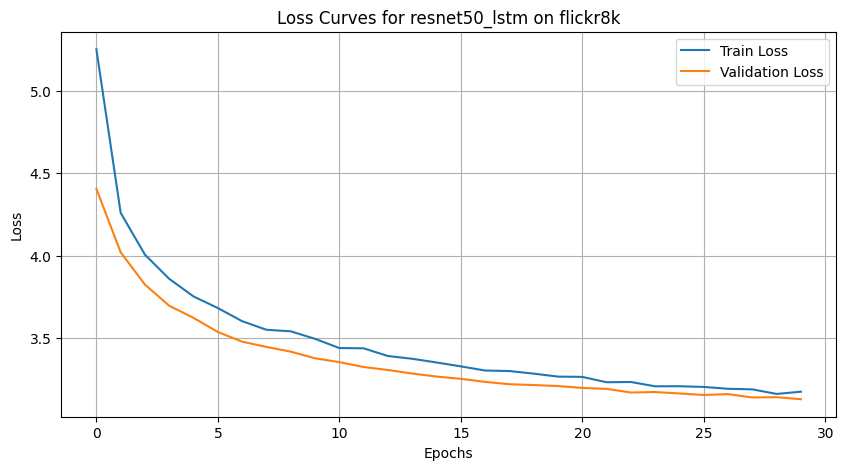

#### Evaluation Metrics

|   Bleu_1 |   Bleu_2 |   Bleu_3 |   Bleu_4 |   METEOR |   ROUGE_L |   CIDEr |   SPICE |
|---------:|---------:|---------:|---------:|---------:|----------:|--------:|--------:|
|    0.562 |    0.368 |    0.226 |    0.141 |    0.172 |     0.413 |   0.328 |   0.105 |


           QUALITATIVE ANALYSIS: GENERATED CAPTIONS



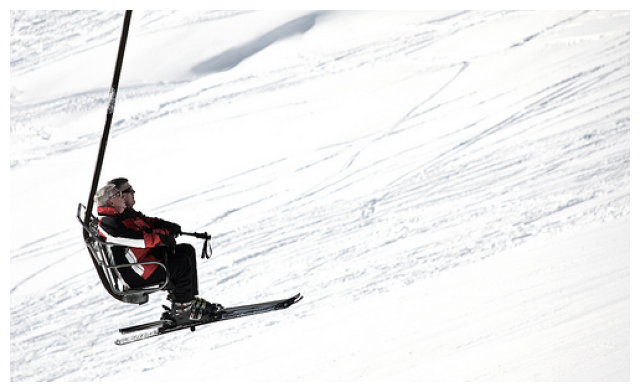

**Generated Caption:** `a man is riding a bike on a snowy hill`

**Ground Truths:**

- *a man rides a ski lift up a mountain *

- *the man and woman ride the ski lift up the snowy mountain *

- *two men sit on a chairlift *

- *two people ride up the mountain on a ski life *

- *two people wearing skis on chairlift*

--------------------------------------------------


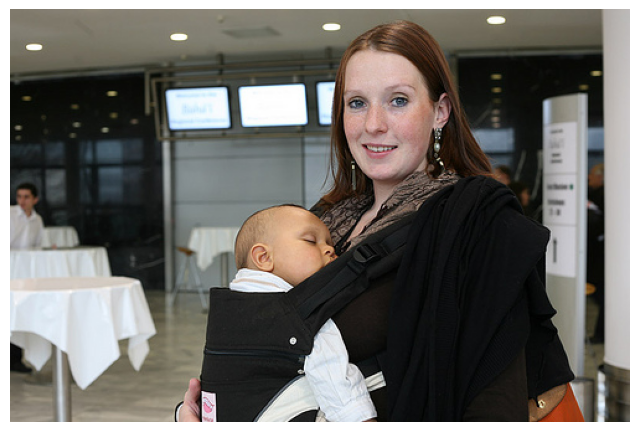

**Generated Caption:** `a woman in a black shirt is standing on a bench with a man in a red shirt and a woman`

**Ground Truths:**

- *a redhaired woman carries a baby on her chest in a carrier *

- *a redheaded woman with a baby in a harness *

- *a woman holding a baby in a pouch on the front of her body *

- *a woman is carrying a sleeping baby in a sling on her chest *

- *the woman holds a small infant in a baby carrier on her chest *

--------------------------------------------------


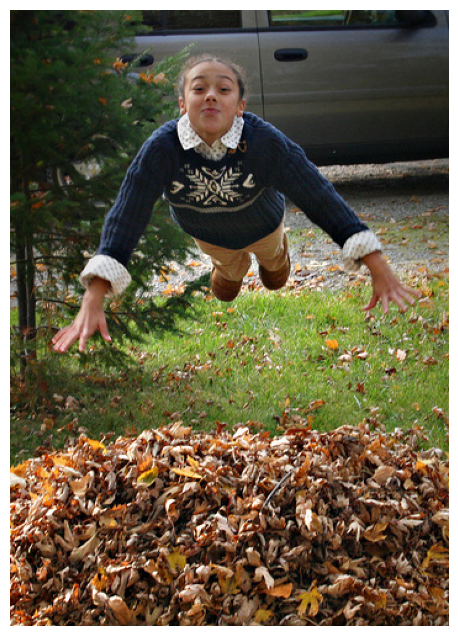

**Generated Caption:** `a boy in a red shirt is jumping on a swing`

**Ground Truths:**

- *a girl in a blue sweater with a white pattern is jumping into a pile of leaves *

- *a girl in a sweater diving into a pile of leaves *

- *a girl is jumping into a pile of leaves*

- *a girl is jumping into a pile of leaves *

- *a young girl is diving into a pile of brown leaves in the yard *

--------------------------------------------------


## 📊 Results for Dataset: `flickr30k`

### 🔬 Experiment: `resnet50_lstm`

**Performance Summary for flickr30k - resnet50 + lstm**
| Metric | Value |
| :--- | :--- |
| **GPU Used** | NVIDIA GeForce RTX 4090 |
| **Total Parameters** | 38,611,916 |
| **Trainable Parameters** | 30,068,620 |
| | |
| **Trainable Breakdown** | |
| &nbsp; &nbsp; Encoder | 14,964,736 |
| &nbsp; &nbsp; Decoder | 14,054,796 |
| &nbsp; &nbsp; Projection Head | 1,049,088 |
| | |
| **Training Details** | |
| &nbsp; &nbsp; Total Epochs Trained | 30 |
| &nbsp; &nbsp; Batch Size | 96 |
| &nbsp; &nbsp; Decoder LR | 0.00015 |
| &nbsp; &nbsp; Encoder LR | 0.0001 |
| &nbsp; &nbsp; Optimizer | AdamW |
| &nbsp; &nbsp; Vocab Size | 9612 |
| &nbsp; &nbsp; Dropout | 0.3 |
| &nbsp; &nbsp; LSTM Hidden Size | 512 |
| &nbsp; &nbsp; LSTM Layers | 2 |
| | |
| **Timings** | |
| &nbsp; &nbsp; Total Training Time | 4581.04 s (76.35 min) |
| &nbsp; &nbsp; Average Time per Epoch | 78.41 s |
| &nbsp; &nbsp; Average Time per Iteration | 0.0527 s |


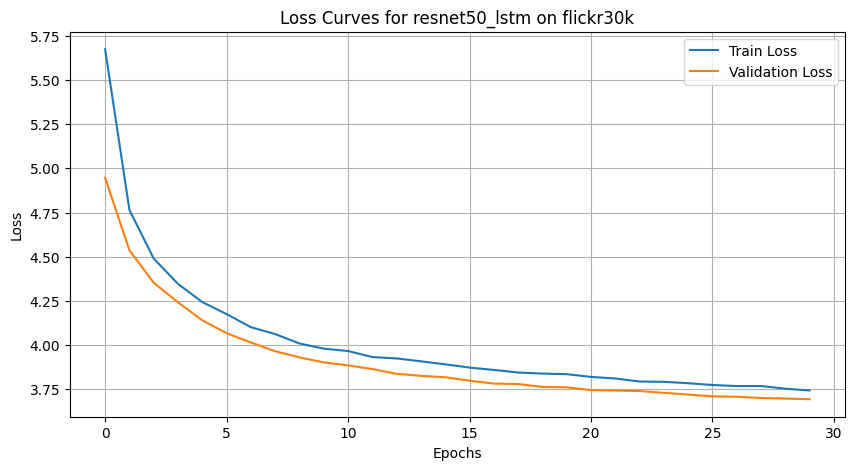

#### Evaluation Metrics

|   Bleu_1 |   Bleu_2 |   Bleu_3 |   Bleu_4 |   METEOR |   ROUGE_L |   CIDEr |   SPICE |
|---------:|---------:|---------:|---------:|---------:|----------:|--------:|--------:|
|    0.533 |    0.344 |    0.217 |     0.14 |    0.153 |     0.397 |   0.195 |   0.088 |


           QUALITATIVE ANALYSIS: GENERATED CAPTIONS



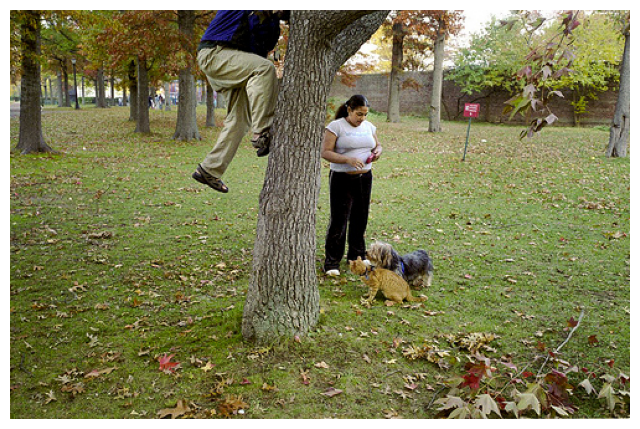

**Generated Caption:** `a man in a black shirt and a black dog is running on a field`

**Ground Truths:**

- *fat man climbs a tree but his fat girl friend and dumb dogs wearing sweaters are not impressed *

- *a large man attempts to climb a tree while a cat dog sit near him *

- *a person wearing a blue shirt and khaki pants climbing in a tree *

- *a man climbing a tree while a woman is below with her dogs *

- *a woman with two dogs standing near a man climbing a tree *

--------------------------------------------------


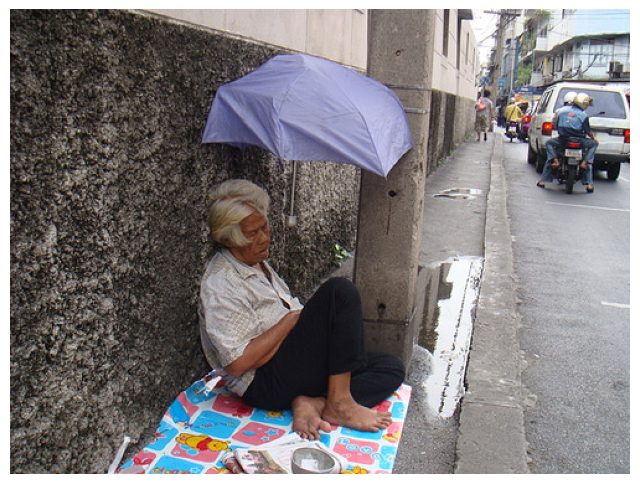

**Generated Caption:** `a man in a blue shirt is sitting on a bench`

**Ground Truths:**

- *a grayhaired shoeless woman is sitting on a blanket under a lavendar umbrella on the side of a street *

- *a woman that appears to be homeless sits on a winnie the pooh table cover on the side of a street *

- *the person is sitting on a winnie the pooh sheet and holding a purple umbrella *

- *the man is sitting outside on the street under a purple umbrella *

- *a man leaning against a wall with an umbrella *

--------------------------------------------------


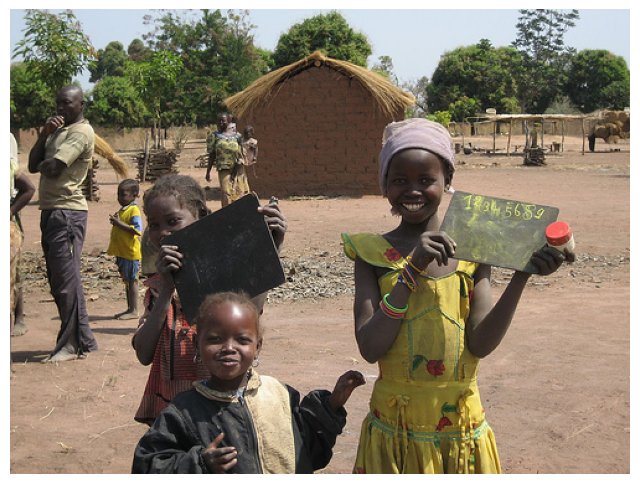

**Generated Caption:** `a man and a woman are sitting on a bench`

**Ground Truths:**

- *in front of a brick house with a straw roof and some figures three children stand two of them holding squares of blackboard *

- *a group of african children display symbols written on chalkboards in the middle of a dirt field *

- *young children in traditional african clothing smile in front of their village *

- *african children holding up signs in their village *

- *black children are holding illegible signs *

--------------------------------------------------


In [10]:
def plot_loss_curves(history, exp_name, dataset_name):
    if not history or 'train_loss' not in history or 'valid_loss' not in history:
        print("No training history found to plot.")
        return
    
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['valid_loss'], label='Validation Loss')
    plt.title(f'Loss Curves for {exp_name} on {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def display_metrics_table(metrics):
    if not metrics:
        print("No metrics to display.")
        return
    
    df = pd.DataFrame([metrics])
    df = df.round(3)
    display(Markdown(df.to_markdown(index=False)))

def display_performance_summary(run_data):
    model = run_data['model']
    training_history = run_data['history']
    total_training_duration = run_data.get('duration', 0)
    train_loader_len = run_data.get('train_loader_len', 0)
    cfg = run_data['cfg']
    config = run_data['config']

    if training_history:
        total_epochs_trained = len(training_history['train_loss'])
        avg_epoch_time = sum(training_history['epoch_times']) / len(training_history['epoch_times']) if training_history.get('epoch_times') else 0
        iterations_per_epoch = train_loader_len
        avg_iteration_time = avg_epoch_time / iterations_per_epoch if iterations_per_epoch > 0 else 0
    else:
        total_epochs_trained = "N/A (Loaded from checkpoint)"
        avg_epoch_time = 0
        avg_iteration_time = 0

    # Parameter breakdown
    encoder_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
    decoder_params = sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
    proj_params = 0
    if hasattr(model, 'feature_proj'):
        proj_params = sum(p.numel() for p in model.feature_proj.parameters() if p.requires_grad)
    
    summary_md = f"""**Performance Summary for {config['dataset_name']} - {cfg.encoder_name} + {cfg.decoder_name}**
| Metric | Value |
| :--- | :--- |
| **GPU Used** | {torch.cuda.get_device_name(0) if cfg.device.type == 'cuda' else 'CPU'} |
| **Total Parameters** | {sum(p.numel() for p in model.parameters()):,} |
| **Trainable Parameters** | {sum(p.numel() for p in model.parameters() if p.requires_grad):,} |
| | |
| **Trainable Breakdown** | |
| &nbsp; &nbsp; Encoder | {encoder_params:,} |
| &nbsp; &nbsp; Decoder | {decoder_params:,} |
"""
    if proj_params > 0:
        summary_md += f"| &nbsp; &nbsp; Projection Head | {proj_params:,} |\n"

    summary_md += f"""| | |
| **Training Details** | |
| &nbsp; &nbsp; Total Epochs Trained | {total_epochs_trained} |
| &nbsp; &nbsp; Batch Size | {cfg.batch_size} |
| &nbsp; &nbsp; Decoder LR | {cfg.decoder_lr} |
| &nbsp; &nbsp; Encoder LR | {cfg.encoder_lr} |
| &nbsp; &nbsp; Optimizer | AdamW |
| &nbsp; &nbsp; Vocab Size | {len(run_data['vocab'])} |
| &nbsp; &nbsp; Dropout | {cfg.dropout} |
"""
    if cfg.decoder_name == 'lstm':
        summary_md += f"| &nbsp; &nbsp; LSTM Hidden Size | {cfg.hidden_dim} |\n"
        summary_md += f"| &nbsp; &nbsp; LSTM Layers | {cfg.num_layers} |\n"

    summary_md += f"""| | |
| **Timings** | |
| &nbsp; &nbsp; Total Training Time | {total_training_duration:.2f} s ({total_training_duration/60:.2f} min) |
| &nbsp; &nbsp; Average Time per Epoch | {avg_epoch_time:.2f} s |
| &nbsp; &nbsp; Average Time per Iteration | {avg_iteration_time:.4f} s |
"""
    display(Markdown(summary_md))

def show_qualitative_results(run_data, num_examples=3):
    if 'generated_captions' not in run_data or 'ground_truths' not in run_data:
        print("Qualitative results not available.")
        return
        
    print("\n" + "="*50)
    print("           QUALITATIVE ANALYSIS: GENERATED CAPTIONS")
    print("="*50 + "\n")
    
    generated_map = {item['image_id']: item['caption'] for item in run_data['generated_captions']}
    gt_map = {}
    for ann in run_data['ground_truths']['annotations']:
        img_id = ann['image_id']
        if img_id not in gt_map:
            gt_map[img_id] = []
        gt_map[img_id].append(ann['caption'])
        
    image_ids = random.sample(list(generated_map.keys()), min(num_examples, len(generated_map)))
    
    for image_id in image_ids:
        image_path = os.path.join(run_data['config']['image_dir'], image_id)
        if not os.path.exists(image_path):
            continue
            
        plt.figure(figsize=(8, 8))
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        
        display(Markdown(f"**Generated Caption:** `{generated_map[image_id]}`"))
        display(Markdown("**Ground Truths:**"))
        for gt_caption in gt_map.get(image_id, []):
            display(Markdown(f"- *{gt_caption}*"))
        print("-"*50)
        

def generate_final_report(results):
    print("\n" + "="*60)
    print("           FINAL COMPARATIVE ANALYSIS")
    print("="*60 + "\n")
    
    for dataset_name, exps in results.items():
        display(Markdown(f'## 📊 Results for Dataset: `{dataset_name}`'))
        for exp_name, run_data in exps.items():
            display(Markdown(f'### 🔬 Experiment: `{exp_name}`'))
            
            # --- Performance Summary ---
            display_performance_summary(run_data)
            
            # --- Loss Curves ---
            plot_loss_curves(run_data.get('history'), exp_name, dataset_name)
            
            # --- Metrics Table ---
            display(Markdown("#### Evaluation Metrics"))
            display_metrics_table(run_data.get('metrics'))
            
            # --- Qualitative Examples ---
            if run_data['cfg'].run_evaluation:
                show_qualitative_results(run_data)
            
            sys.stdout.flush() # Ensure outputs are displayed in order
            time.sleep(1.0)


if __name__ == '__main__':
    if BaseCFG.run_evaluation:
        generate_final_report(results_history)


### **Final Review Checklist**
This checklist confirms that all identified bugs and robustness improvements have been integrated into the script.

| ID | Status | Description | Location of Fix |
| :--- | :--- | :--- | :--- |
| 1 | ✅ | Dependencies are explicitly installed (`pycocoevalcap`, `albumentations`, `tabulate`). | Step 1 |
| 2 | ✅ | System dependencies (`java`, `zip`) are installed. | Step 1 |
| 3 | ✅ | A compatible PyTorch version is forcibly installed to prevent CUDA errors. | Step 1 |
| 4 | ✅ | A compatible NumPy version (`<2.0`) is explicitly installed. | Step 1 |
| 5 | ✅ | The data processing pipeline correctly parses image filenames from `captions.txt`. | Step 3 |
| 6 | ✅ | The `torch.load` call for the vocabulary object uses `weights_only=False`. | Step 8 |
| 7 | ✅ | Teacher-forcing slicing (`[:, :-1]`) is handled correctly and consistently in the `Trainer`. | Step 6 |
| 8 | ✅ | The GPT-2 `generate` method is correctly passed the `eos_token_id`. | Step 5 |
| 9 | ✅ | The ground-truth JSON for evaluation includes the required `"info"` key. | Step 7 |
| 10 | ✅ | The `base_path` variable is correctly defined in the global scope. | Step 1 |